In [115]:
import numpy as np
from typing import List
import random
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import itertools

In [116]:
import matplotlib.pyplot as plt
import numpy as np

def plot_value_table(v_table, iteration_count, capacity_a, capacity_b):
    """
    使用 matplotlib 绘制 v_table 的网格图。

    参数:
    v_table (dict): 包含状态价值的字典，键为 (i, j) 元组。
    capacity_a (int): 地点 A 的最大容量。
    capacity_b (int): 地点 B 的最大容量。
    """
    
    # 将字典形式的 v_table 转换为 numpy 数组
    # v_table 是 (i, j) -> value，i 是行，j 是列
    grid = np.zeros((capacity_a + 1, capacity_b + 1))
    for i in range(capacity_a + 1):
        for j in range(capacity_b + 1):
            grid[i, j] = v_table.get((i, j), 0) # 使用 .get() 以防某些键缺失

    # 创建一个图和子图
    fig, ax = plt.subplots(figsize=(capacity_b + 1, capacity_a + 1))
    
    # 绘制热力图，cmap='viridis' 是一个不错的颜色映射
    im = ax.imshow(grid, cmap='viridis', origin='lower')
    
    # 设置网格
    ax.set_xticks(np.arange(capacity_b + 1))
    ax.set_yticks(np.arange(capacity_a + 1))
    ax.set_xticklabels(np.arange(capacity_b + 1))
    ax.set_yticklabels(np.arange(capacity_a + 1))
    ax.set_xlabel("Cars at Location B")
    ax.set_ylabel("Cars at Location A")
    ax.set_title(f"Value Function for {iteration_count} policy")
    
    # 在每个格子里添加数值
    # 这里的循环顺序和imshow的矩阵顺序相反
    for i in range(capacity_a + 1):
        for j in range(capacity_b + 1):
            text = ax.text(j, i, f"{grid[i, j]:.2f}",
                           ha="center", va="center", color="w", fontsize=8)
                           
    # 调整布局，防止标签被裁剪
    fig.tight_layout()
    plt.show()

def plot_policy(policy, iteration_count, capacity_a, capacity_b):
    """
    使用 matplotlib 绘制 Jack's Car Rental 问题的策略图。

    参数:
    policy (dict): 包含状态到动作映射的字典，键为 (i, j) 元组。
    iteration_count (int): 当前迭代次数，用于标题。
    capacity_a (int): 地点 A 的最大容量。
    capacity_b (int): 地点 B 的最大容量。
    """
    
    # 创建一个 numpy 数组来存储策略值，以便于绘图
    policy_grid = np.zeros((capacity_a + 1, capacity_b + 1))
    for i in range(capacity_a + 1):
        for j in range(capacity_b + 1):
            policy_grid[i, j] = policy.get((i, j), 0)

    # 创建图和子图
    fig, ax = plt.subplots(figsize=(capacity_b + 1, capacity_a + 1))
    
    # 绘制热力图，这里使用 policy_grid 的值作为颜色
    # cmap='coolwarm' 是一个不错的颜色映射，可以清晰地区分正负值
    im = ax.imshow(policy_grid, cmap='coolwarm', origin='lower')
    
    # 设置网格
    ax.set_xticks(np.arange(capacity_b + 1))
    ax.set_yticks(np.arange(capacity_a + 1))
    ax.set_xticklabels(np.arange(capacity_b + 1))
    ax.set_yticklabels(np.arange(capacity_a + 1))
    ax.set_xlabel("Cars at Location B")
    ax.set_ylabel("Cars at Location A")
    ax.set_title(f"Policy_{iteration_count}")
    
    # 在每个格子里添加动作数值
    # 这里的循环顺序和imshow的矩阵顺序相反
    for i in range(capacity_a + 1):
        for j in range(capacity_b + 1):
            action = policy_grid[i, j]
            # 颜色选择，根据动作是正还是负来选择
            color = "w" if abs(action) > 10 else "k" 
            text = ax.text(j, i, int(action),
                           ha="center", va="center", color="k", fontsize=10)

    # 在图的旁边添加颜色条，以便理解颜色和动作值的对应关系
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Number of Cars Moved (A to B)")
                           
    # 调整布局
    fig.tight_layout()
    plt.show()


In [127]:
# Parameter
CAPACITY_A = 20
CAPACITY_B = 20

class Location():
    CACHE_LIMIT = 25 
    def __init__(self, capacity: int, rent_mean: int, return_mean: int):
        self.capacity = capacity
        self.rent_mean = rent_mean
        self.return_mean = return_mean

        # 1. 创建用于存储概率的缓存列表
        self._rent_prob_cache = []
        self._return_prob_cache = []

        # 2. 在对象创建时，立即调用方法填充缓存
        self._precompute_probabilities()

    @staticmethod
    def poisson_probability(n: int, mean: int):
        return math.exp(-mean) * (mean ** n) / math.factorial(n)

    def _precompute_probabilities(self):
        """
        一个私有方法，用于预先计算并填充概率缓存。
        这个方法只在 __init__ 中被调用一次。
        """
        for n in range(self.CACHE_LIMIT + 1):
            # 计算并存储租车概率
            rent_prob = self.poisson_probability(n, self.rent_mean)
            self._rent_prob_cache.append(rent_prob)

            # 计算并存储还车概率
            return_prob = self.poisson_probability(n, self.return_mean)
            self._return_prob_cache.append(return_prob)

    def rent_probability(self, n):
        if 0 <= n < len(self._rent_prob_cache):
            return self._rent_prob_cache[n]
        return 0 # 如果n超出了我们缓存的范围，其概率基本为0
    
    def return_probability(self, n):
        if 0 <= n < len(self._return_prob_cache):
            return self._return_prob_cache[n]
        return 0

def calculate_probability(demand, supply, probability_function):
    assert demand <= supply
    if demand == supply:
        p_temp = 0.0
        for i in range(0, demand):
            p_temp += probability_function(i)
        prob = 1 - p_temp
    else:
        prob = probability_function(demand)
    return prob

In [132]:
class Agent():
    def __init__(self):
        # Environment parameters
        self.location_a = Location(CAPACITY_A, 3, 3)
        self.location_b = Location(CAPACITY_B, 4, 2)
        self.gamma = 0.9
        self.max_action = 5

        self.theta = 0.1  # experimental
        self.v_table = {}
        for i in range(CAPACITY_A + 1):
            for j in range(CAPACITY_B + 1):
                self.v_table[(i, j)] = 0

        # initialize policy
        # action positive means moving car from location A to B
        print("Initialize policy by setting all action to 0 for every state")
        self.policy = {}
        for i in range(CAPACITY_A + 1):
            for j in range(CAPACITY_B + 1):
                self.policy[(i, j)] = 0

    def evaluate(self):
        # Evaluate current policy, update self.v_table
        while True:
            delta = 0.0
            for i, j in tqdm(itertools.product(range(CAPACITY_A + 1), range(CAPACITY_B + 1))):
                state = (i, j)
                v = self.v_table[state]
                v_updated = 0
                # update the value
                action = self.policy[state]
                # number of cars in both location after the action at that night
                s_a = i - action
                s_b = j + action
                for n_a in range(0, s_a + 1):
                    p_rent_a = calculate_probability(n_a, s_a, agent.location_a.rent_probability)
                    for r_a in range(0, CAPACITY_A - (s_a - n_a) + 1):
                        p_return_a = calculate_probability(r_a, CAPACITY_A - (s_a - n_a), agent.location_a.return_probability)  # probability for return
                        p_a = p_rent_a * p_return_a
                        next_state_a = s_a - n_a + r_a

                        for n_b in range(0, s_b + 1):
                            p_rent_b = calculate_probability(n_b, s_b, agent.location_b.rent_probability)
                            reward = (n_a + n_b) * 10. - abs(action) * 2.
                            for r_b in range(0, CAPACITY_B - (s_b - n_b) + 1):
                                p_return_b = calculate_probability(r_b, CAPACITY_B - (s_b - n_b), agent.location_b.return_probability)  # probability for return
                                p_b = p_rent_b * p_return_b
                                next_state_b = s_b - n_b + r_b

                                p = p_a * p_b
                                next_state = (next_state_a, next_state_b)
                                value_next_state = self.v_table[next_state]
                                v_updated += p * (reward + self.gamma * value_next_state)
                self.v_table[state] = v_updated
                    
                delta = max(delta, abs(v_updated - v))

            print(delta)
            if delta < self.theta:
                break


Initialize policy by setting all action to 0 for every state
Conduct initial Evaluation


441it [00:03, 140.71it/s]


193.3490492750947


441it [00:03, 142.33it/s]


134.0042608644682


441it [00:03, 142.26it/s]


90.45243773746233


441it [00:03, 146.23it/s]


67.59779106615383


441it [00:03, 146.92it/s]


53.584930617580426


441it [00:03, 144.77it/s]


41.72086291128494


441it [00:03, 142.83it/s]


32.72010939685606


441it [00:02, 147.08it/s]


26.08755613817368


441it [00:03, 146.56it/s]


21.77814339269844


441it [00:03, 143.60it/s]


18.318059790332825


441it [00:03, 146.53it/s]


15.36740634770041


441it [00:03, 145.89it/s]


12.861027123615997


441it [00:03, 141.81it/s]


10.739286690814538


441it [00:03, 142.09it/s]


8.949004145272113


441it [00:03, 144.10it/s]


7.443128433755817


441it [00:03, 145.82it/s]


6.180206266077619


441it [00:03, 144.16it/s]


5.123897292162269


441it [00:03, 146.44it/s]


4.242540347244471


441it [00:03, 143.24it/s]


3.508736868355413


441it [00:03, 144.93it/s]


2.898934555425967


441it [00:03, 144.04it/s]


2.3930120440825817


441it [00:03, 144.17it/s]


1.9738735796696005


441it [00:03, 136.51it/s]


1.6270638320041257


441it [00:03, 140.42it/s]


1.3404108007522382


441it [00:03, 141.25it/s]


1.1037016637392867


441it [00:03, 142.19it/s]


0.9083935811094079


441it [00:03, 142.19it/s]


0.7473592909599915


441it [00:03, 140.30it/s]


0.6146658513113152


441it [00:03, 141.15it/s]


0.5053839897117314


441it [00:03, 142.72it/s]


0.41542507105839377


441it [00:03, 143.45it/s]


0.34140255324280133


441it [00:03, 143.45it/s]


0.2805148621156377


441it [00:03, 142.91it/s]


0.2304468020140007


441it [00:03, 144.07it/s]


0.18928686930109961


441it [00:03, 145.69it/s]


0.15545811562668632


441it [00:03, 145.35it/s]


0.1276604902653844


441it [00:03, 139.75it/s]


0.10482286156775444


441it [00:03, 142.76it/s]


0.08606316780424095


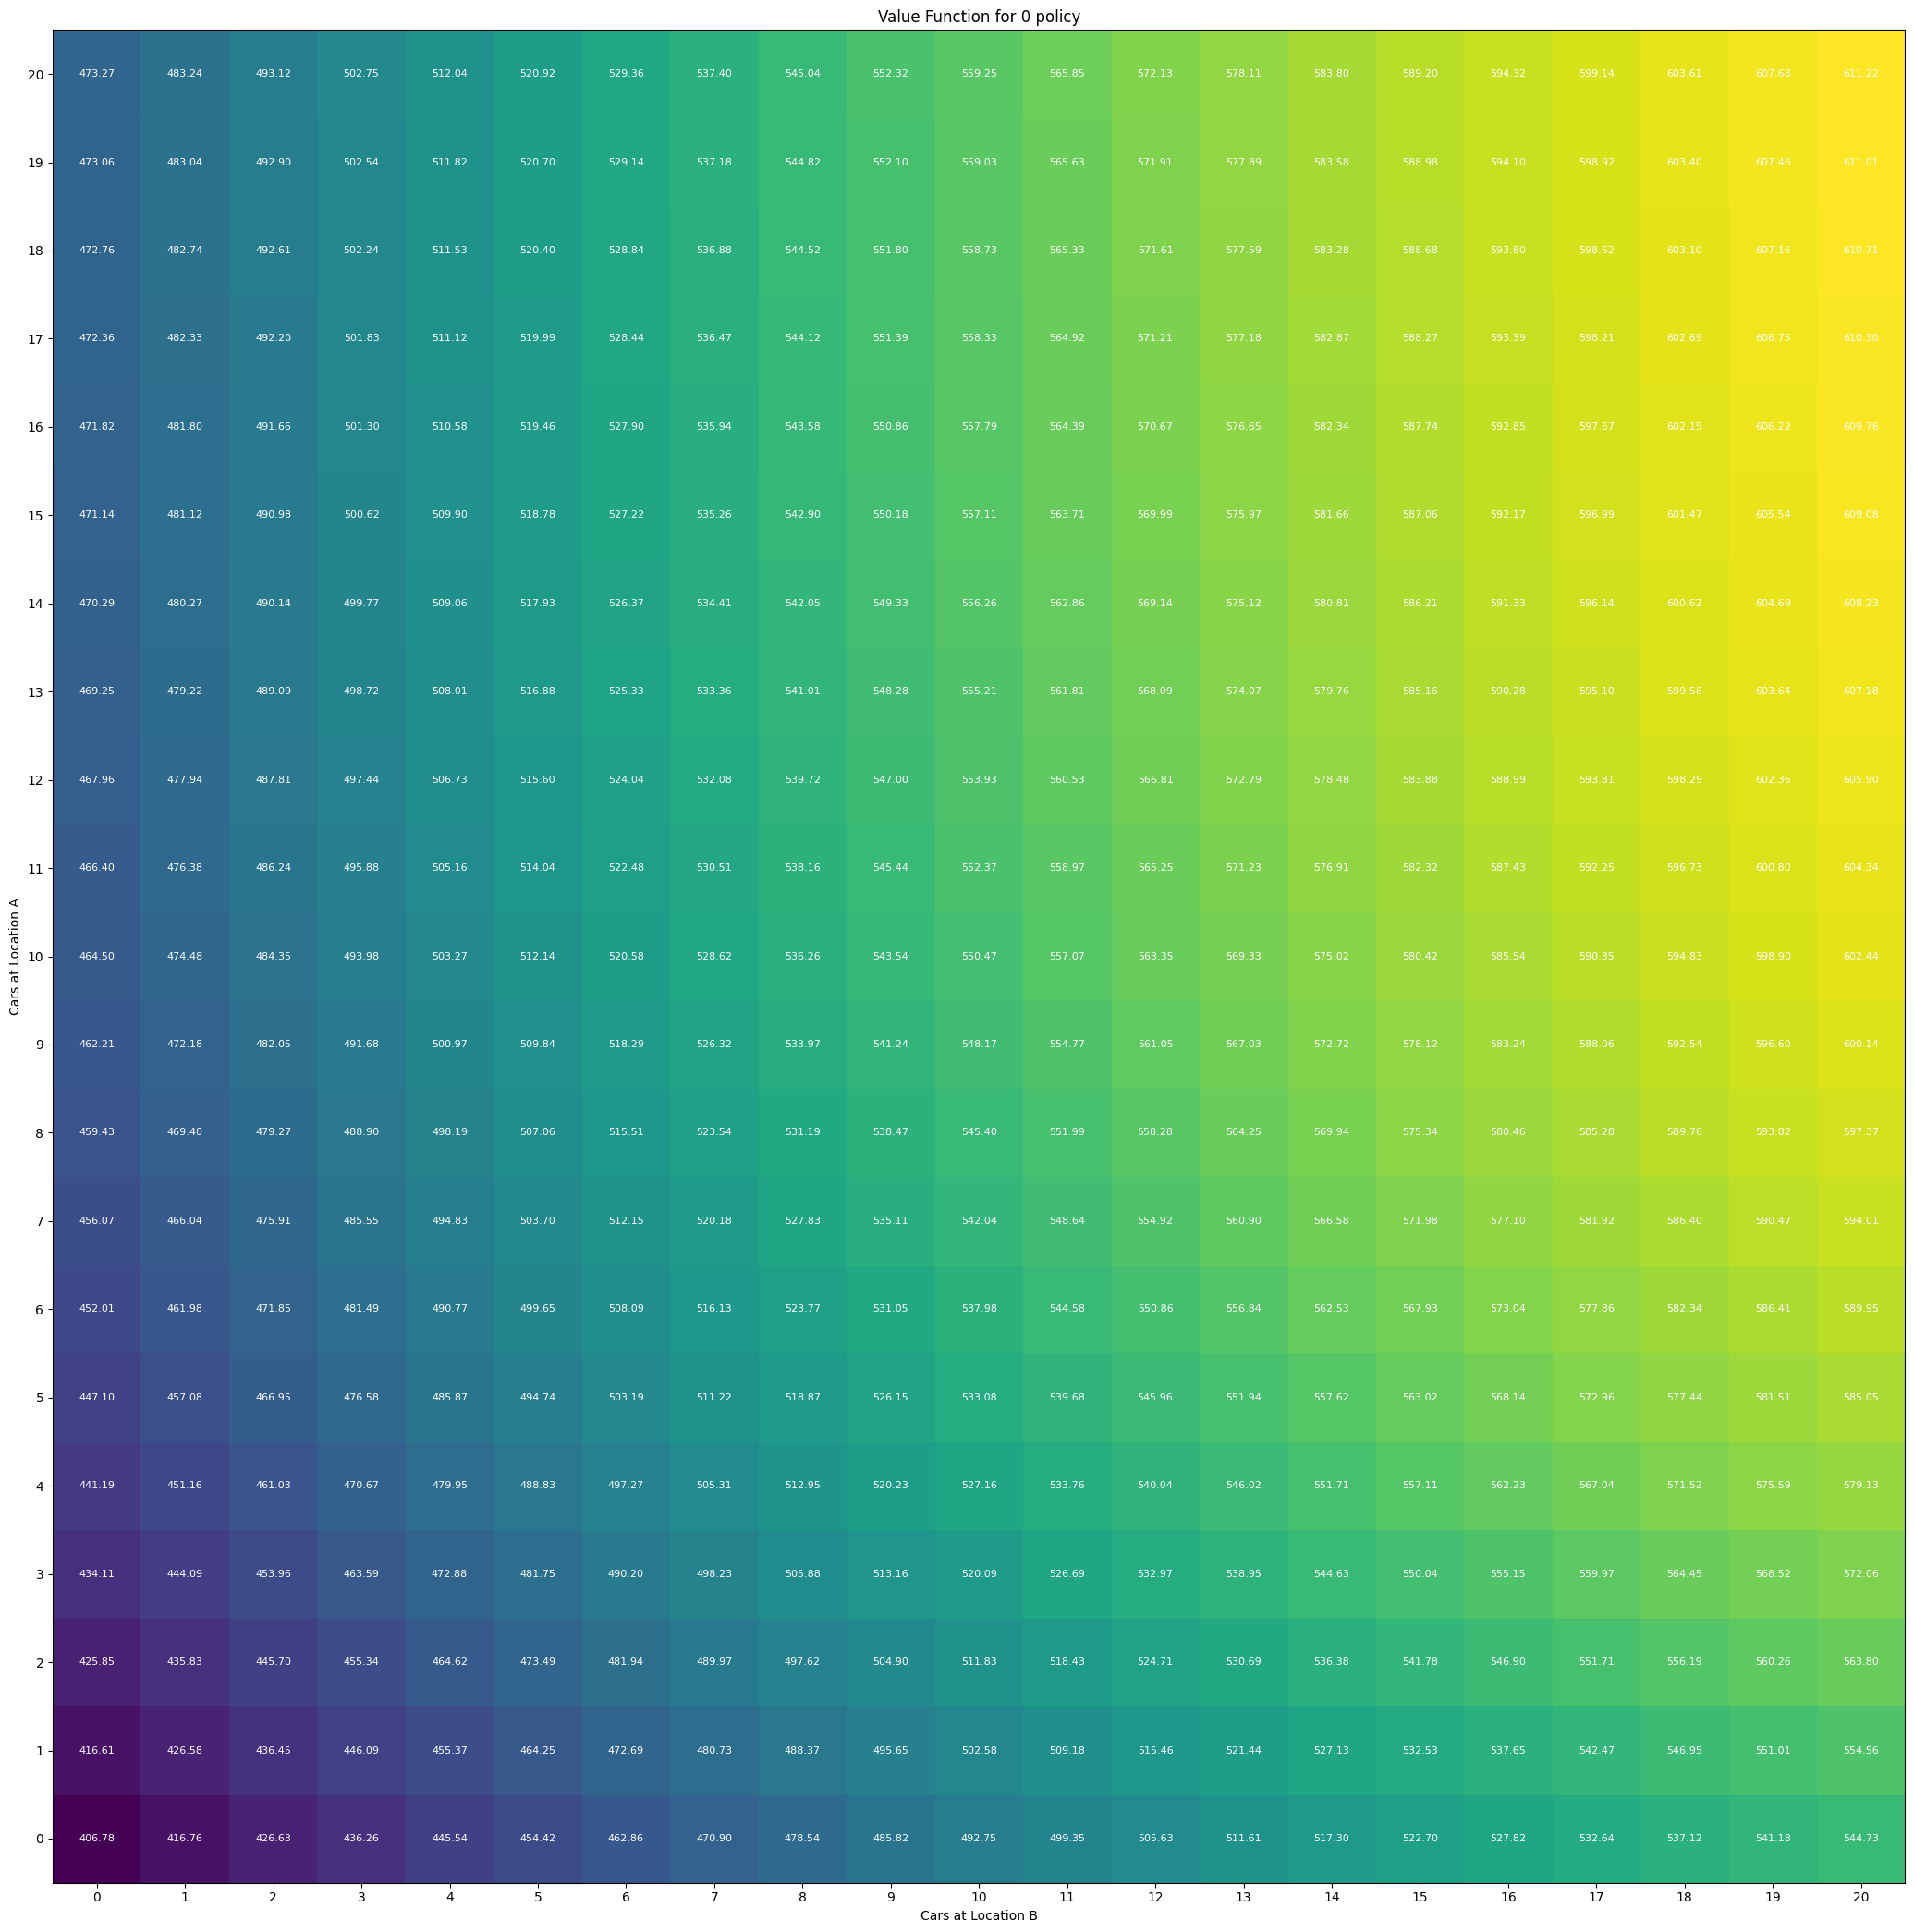

**********Staring 1 iteration


441it [00:38, 11.56it/s]


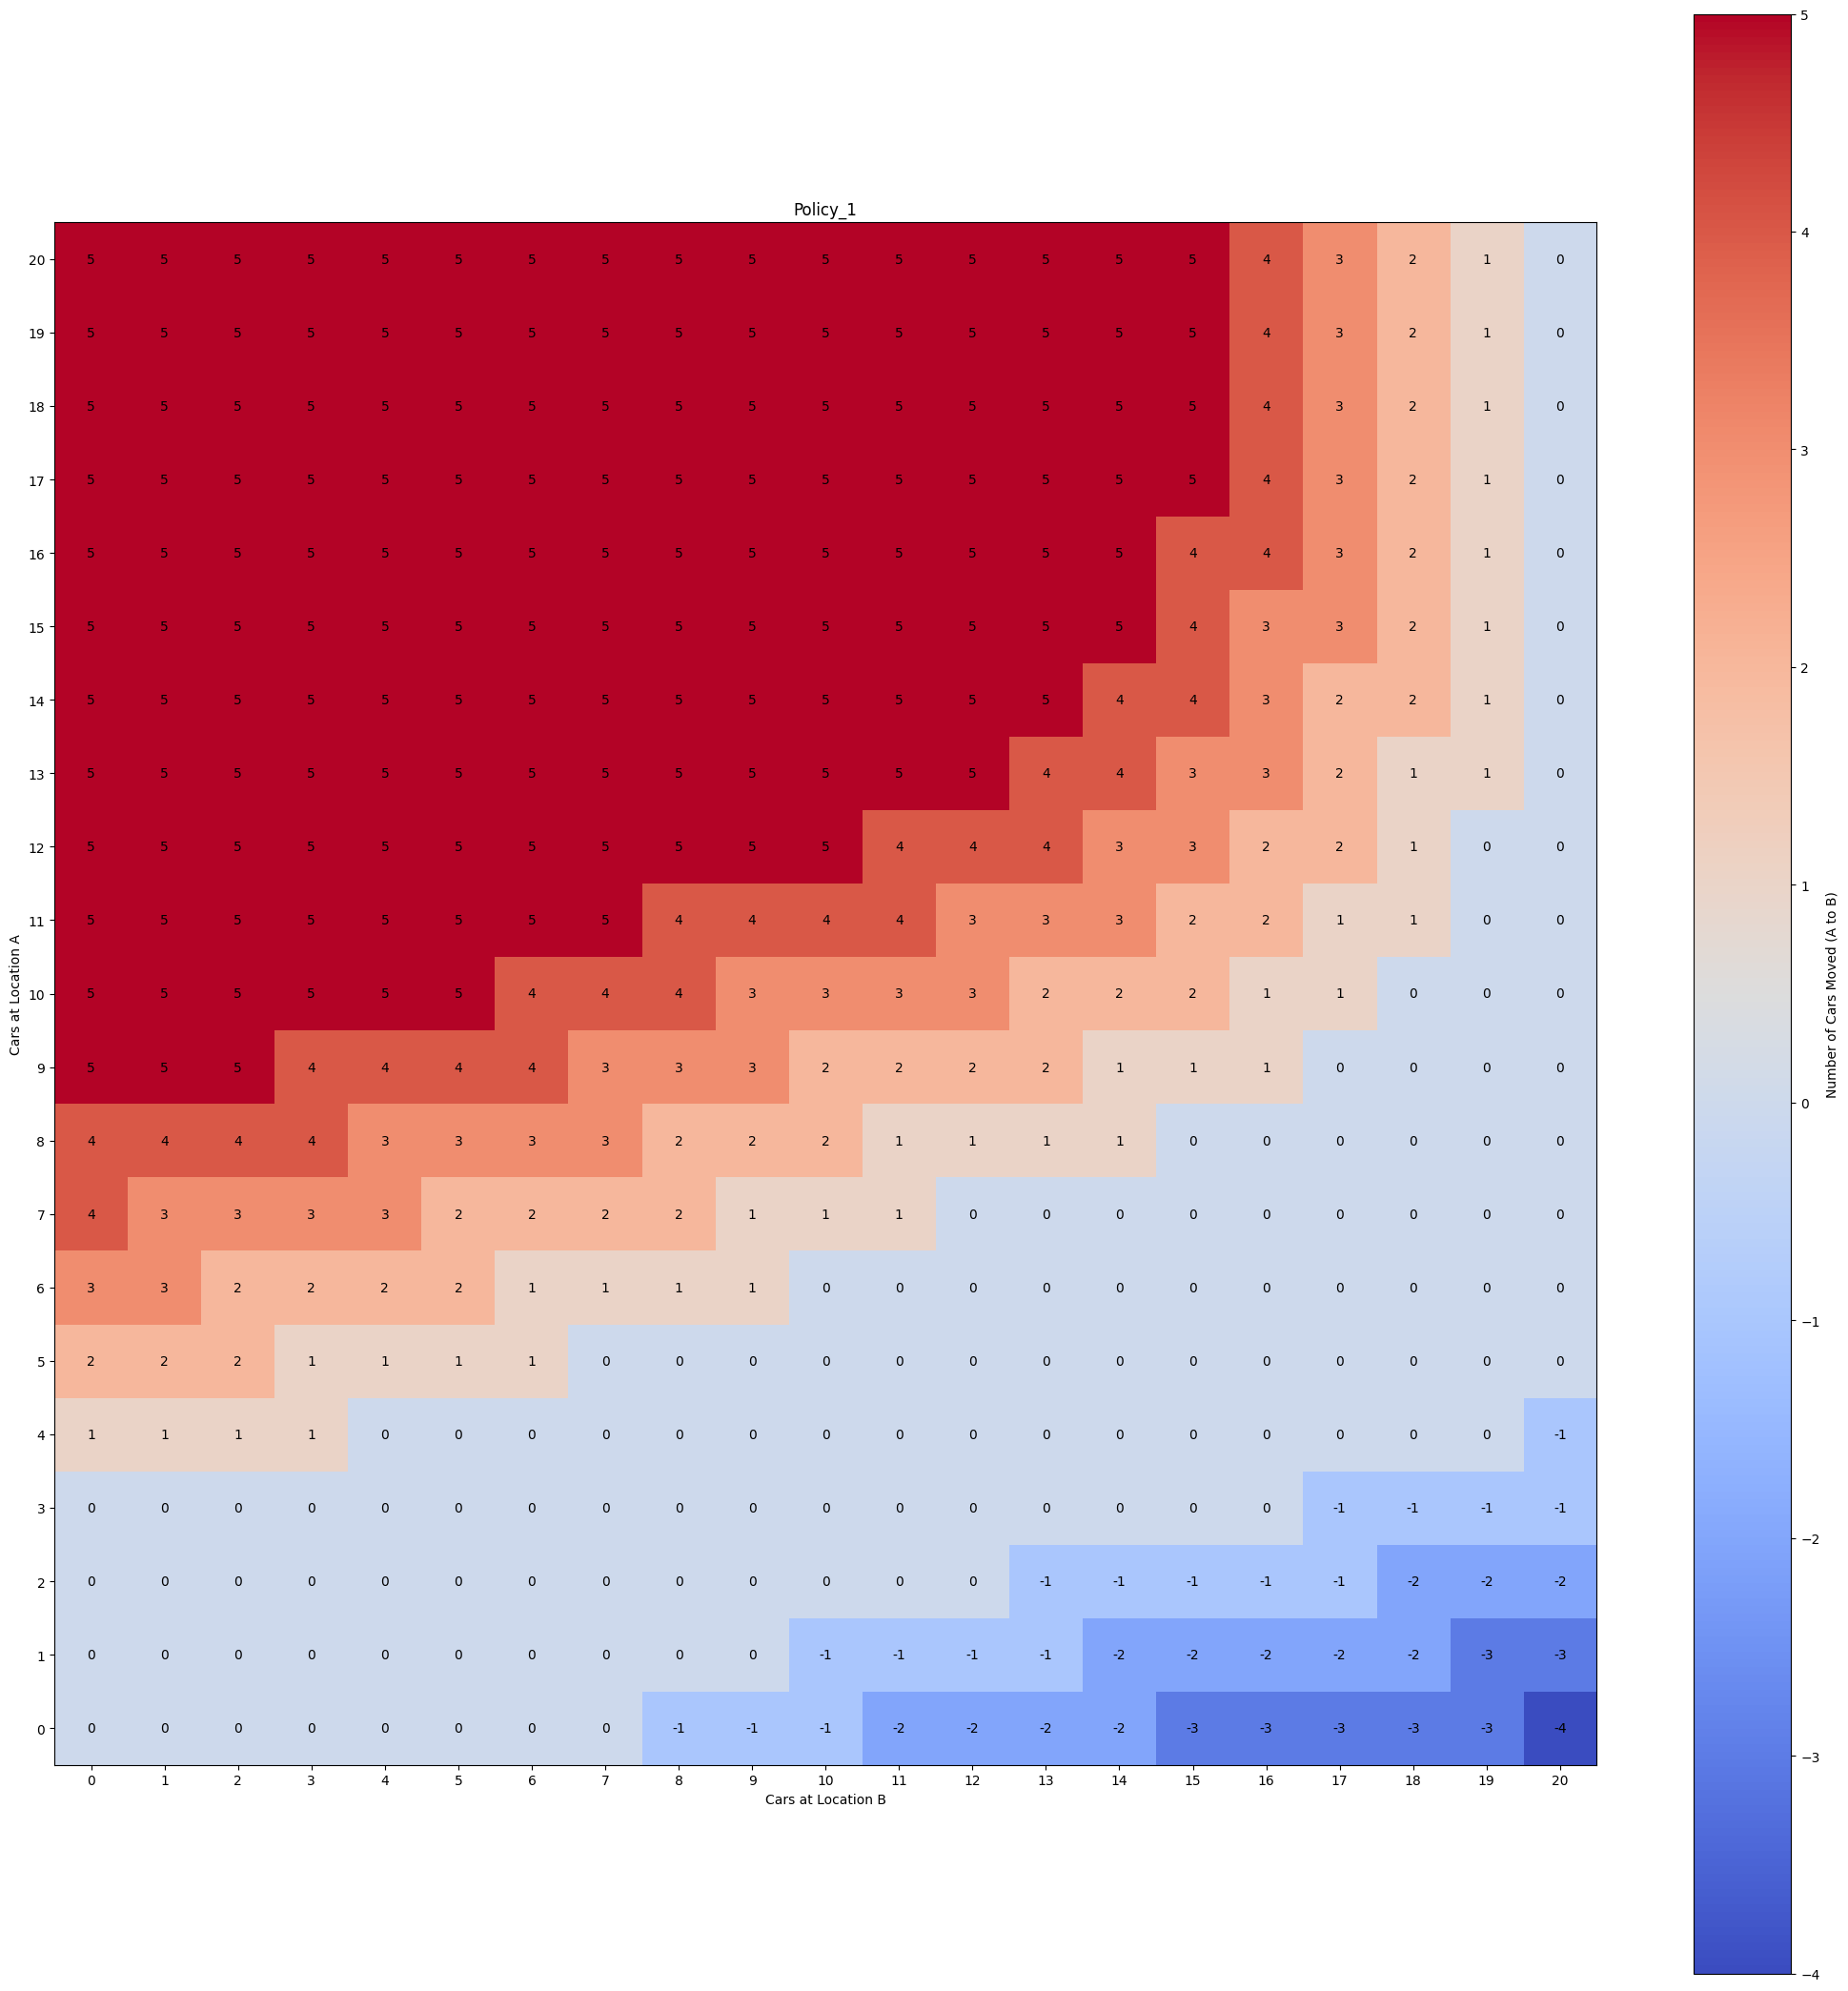

Conduct 1 time evaluation


441it [00:03, 130.12it/s]


64.57595226839538


441it [00:03, 131.61it/s]


4.872618926685732


441it [00:03, 131.71it/s]


2.16619492295888


441it [00:03, 126.84it/s]


1.5734951228223508


441it [00:03, 129.82it/s]


1.364991231374006


441it [00:03, 129.93it/s]


1.1331455203080623


441it [00:03, 127.76it/s]


0.9302166382131531


441it [00:03, 129.59it/s]


0.761936162943357


441it [00:03, 129.24it/s]


0.6237889096311164


441it [00:03, 129.70it/s]


0.5106062561911244


441it [00:03, 128.08it/s]


0.4179307040604954


441it [00:03, 128.80it/s]


0.3420645376057223


441it [00:03, 126.86it/s]


0.2799655101678127


441it [00:03, 128.06it/s]


0.22913793765849277


441it [00:03, 131.31it/s]


0.18753705155853595


441it [00:03, 127.70it/s]


0.15348843831247905


441it [00:03, 128.43it/s]


0.12562129627457352


441it [00:03, 129.27it/s]


0.10281351785670267


441it [00:03, 130.60it/s]


0.08414662965356001


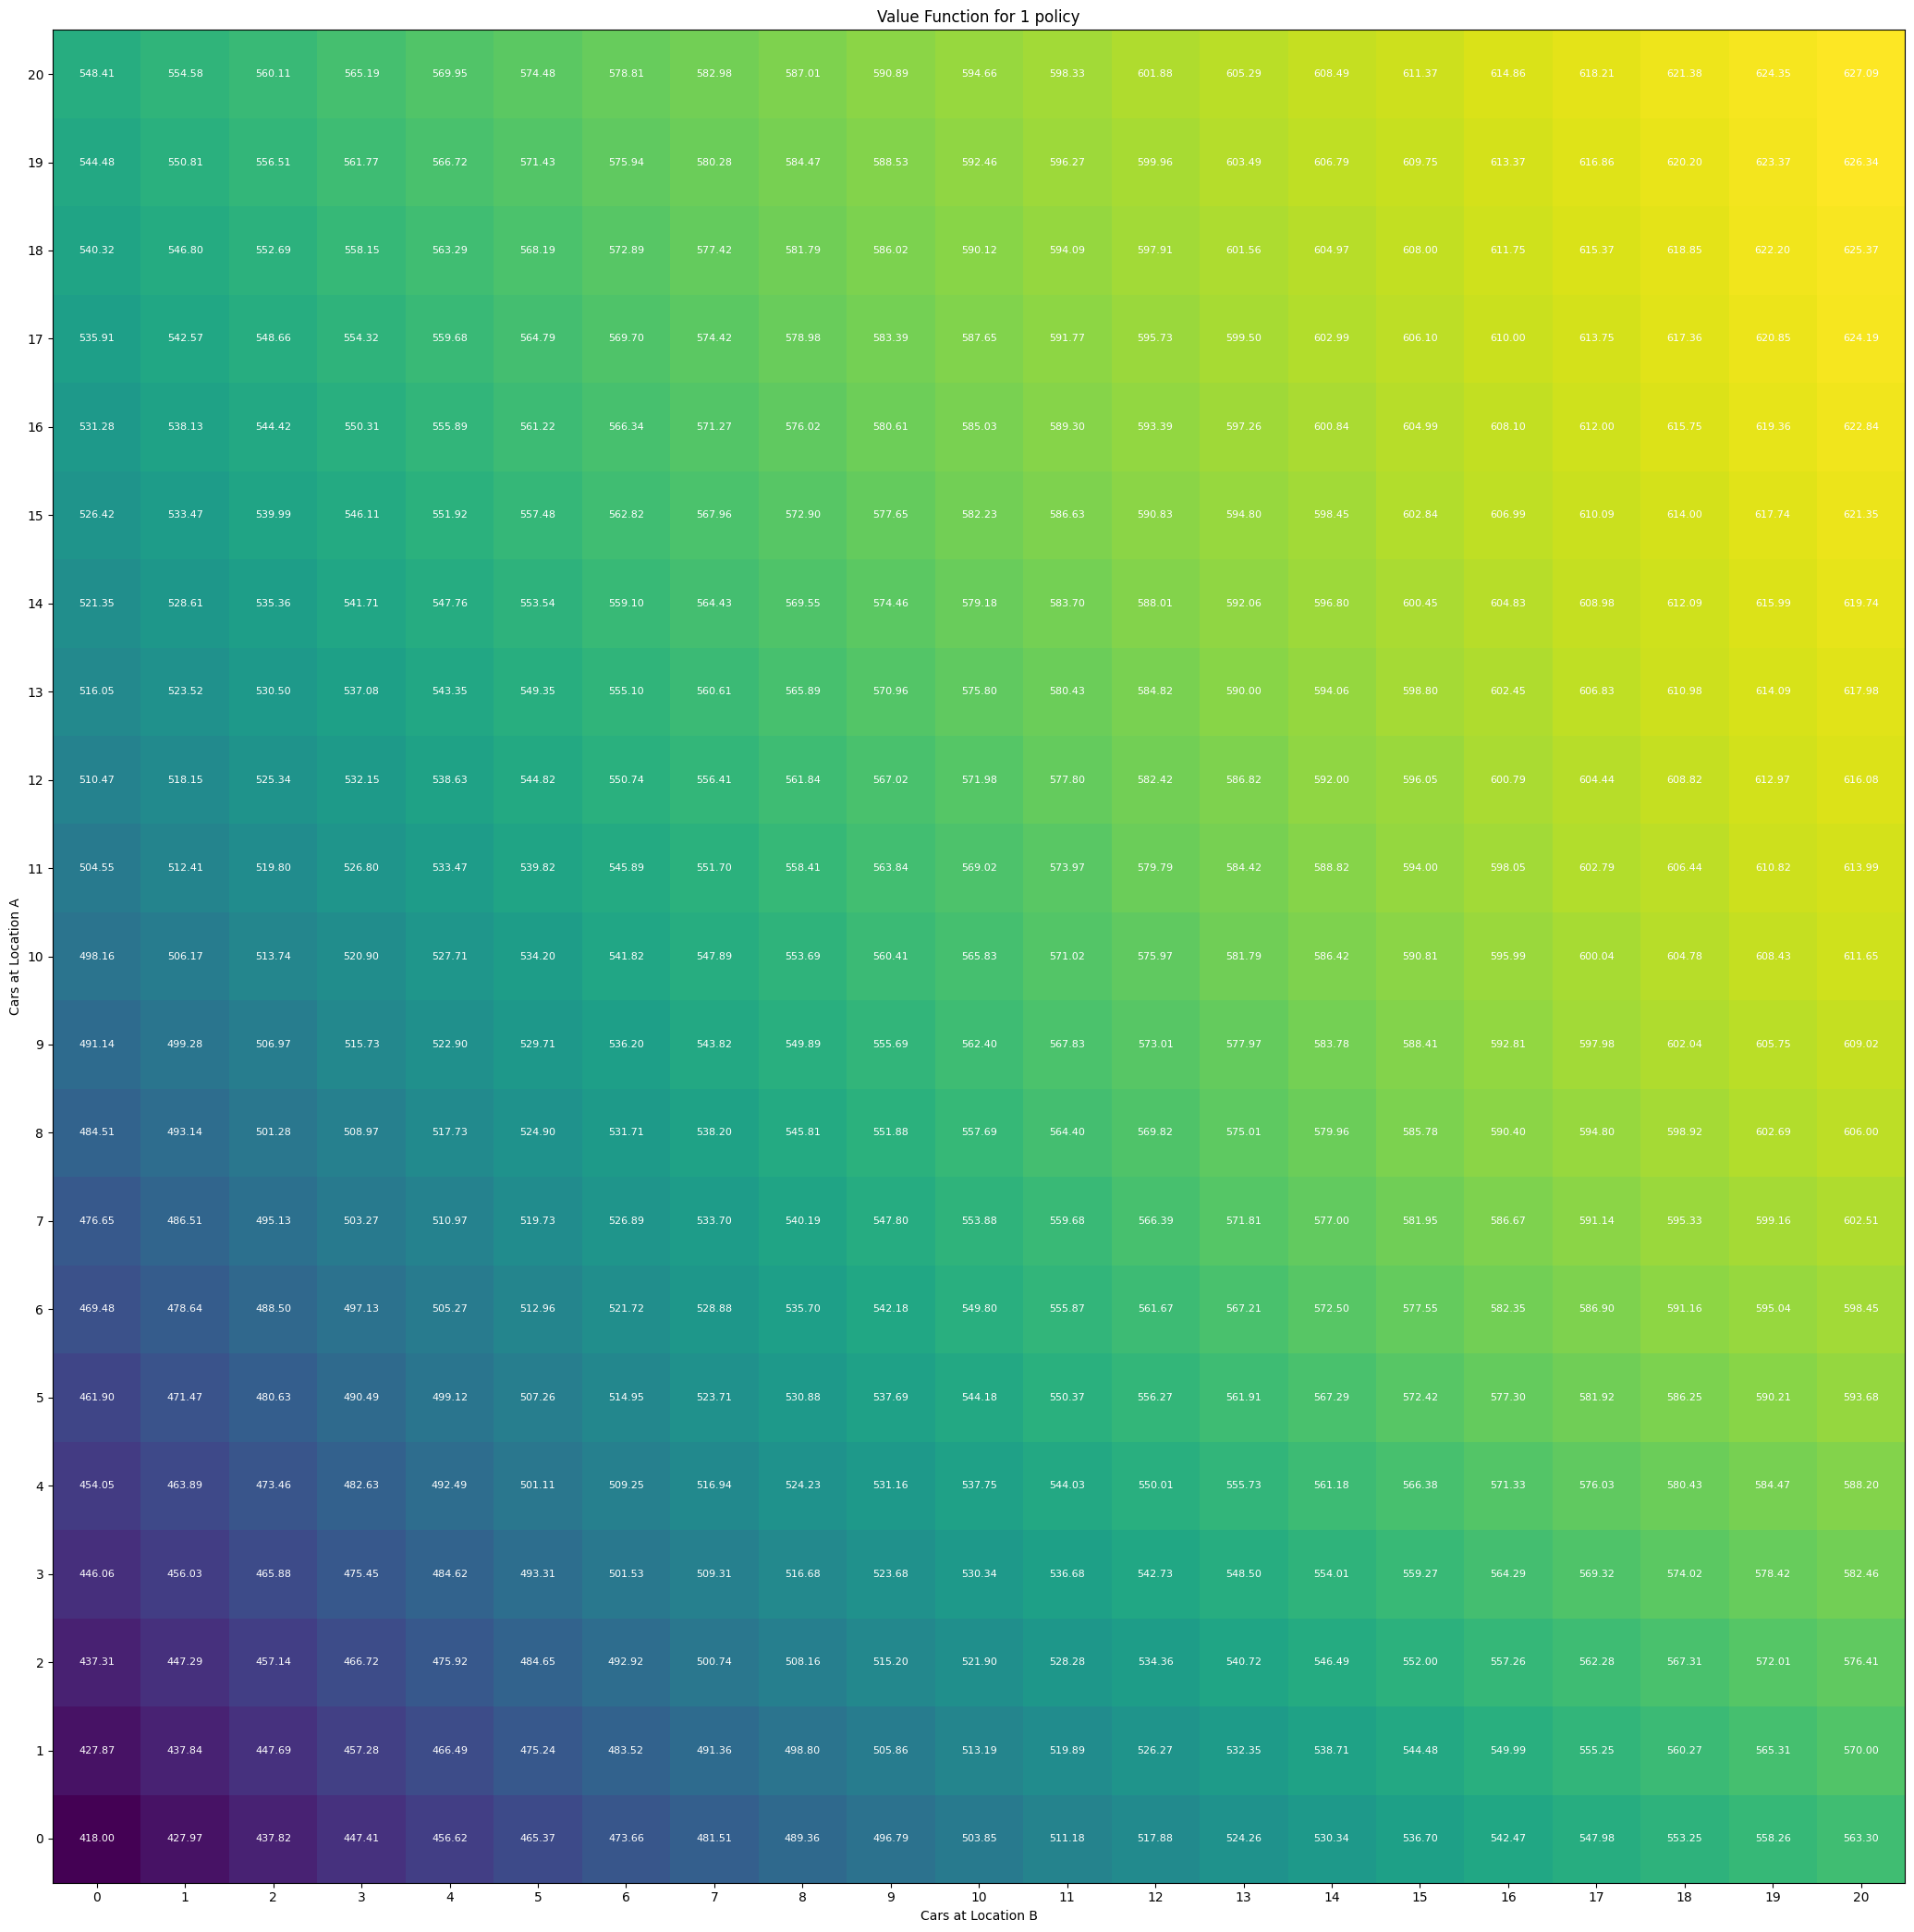

**********Staring 2 iteration


441it [00:37, 11.68it/s]


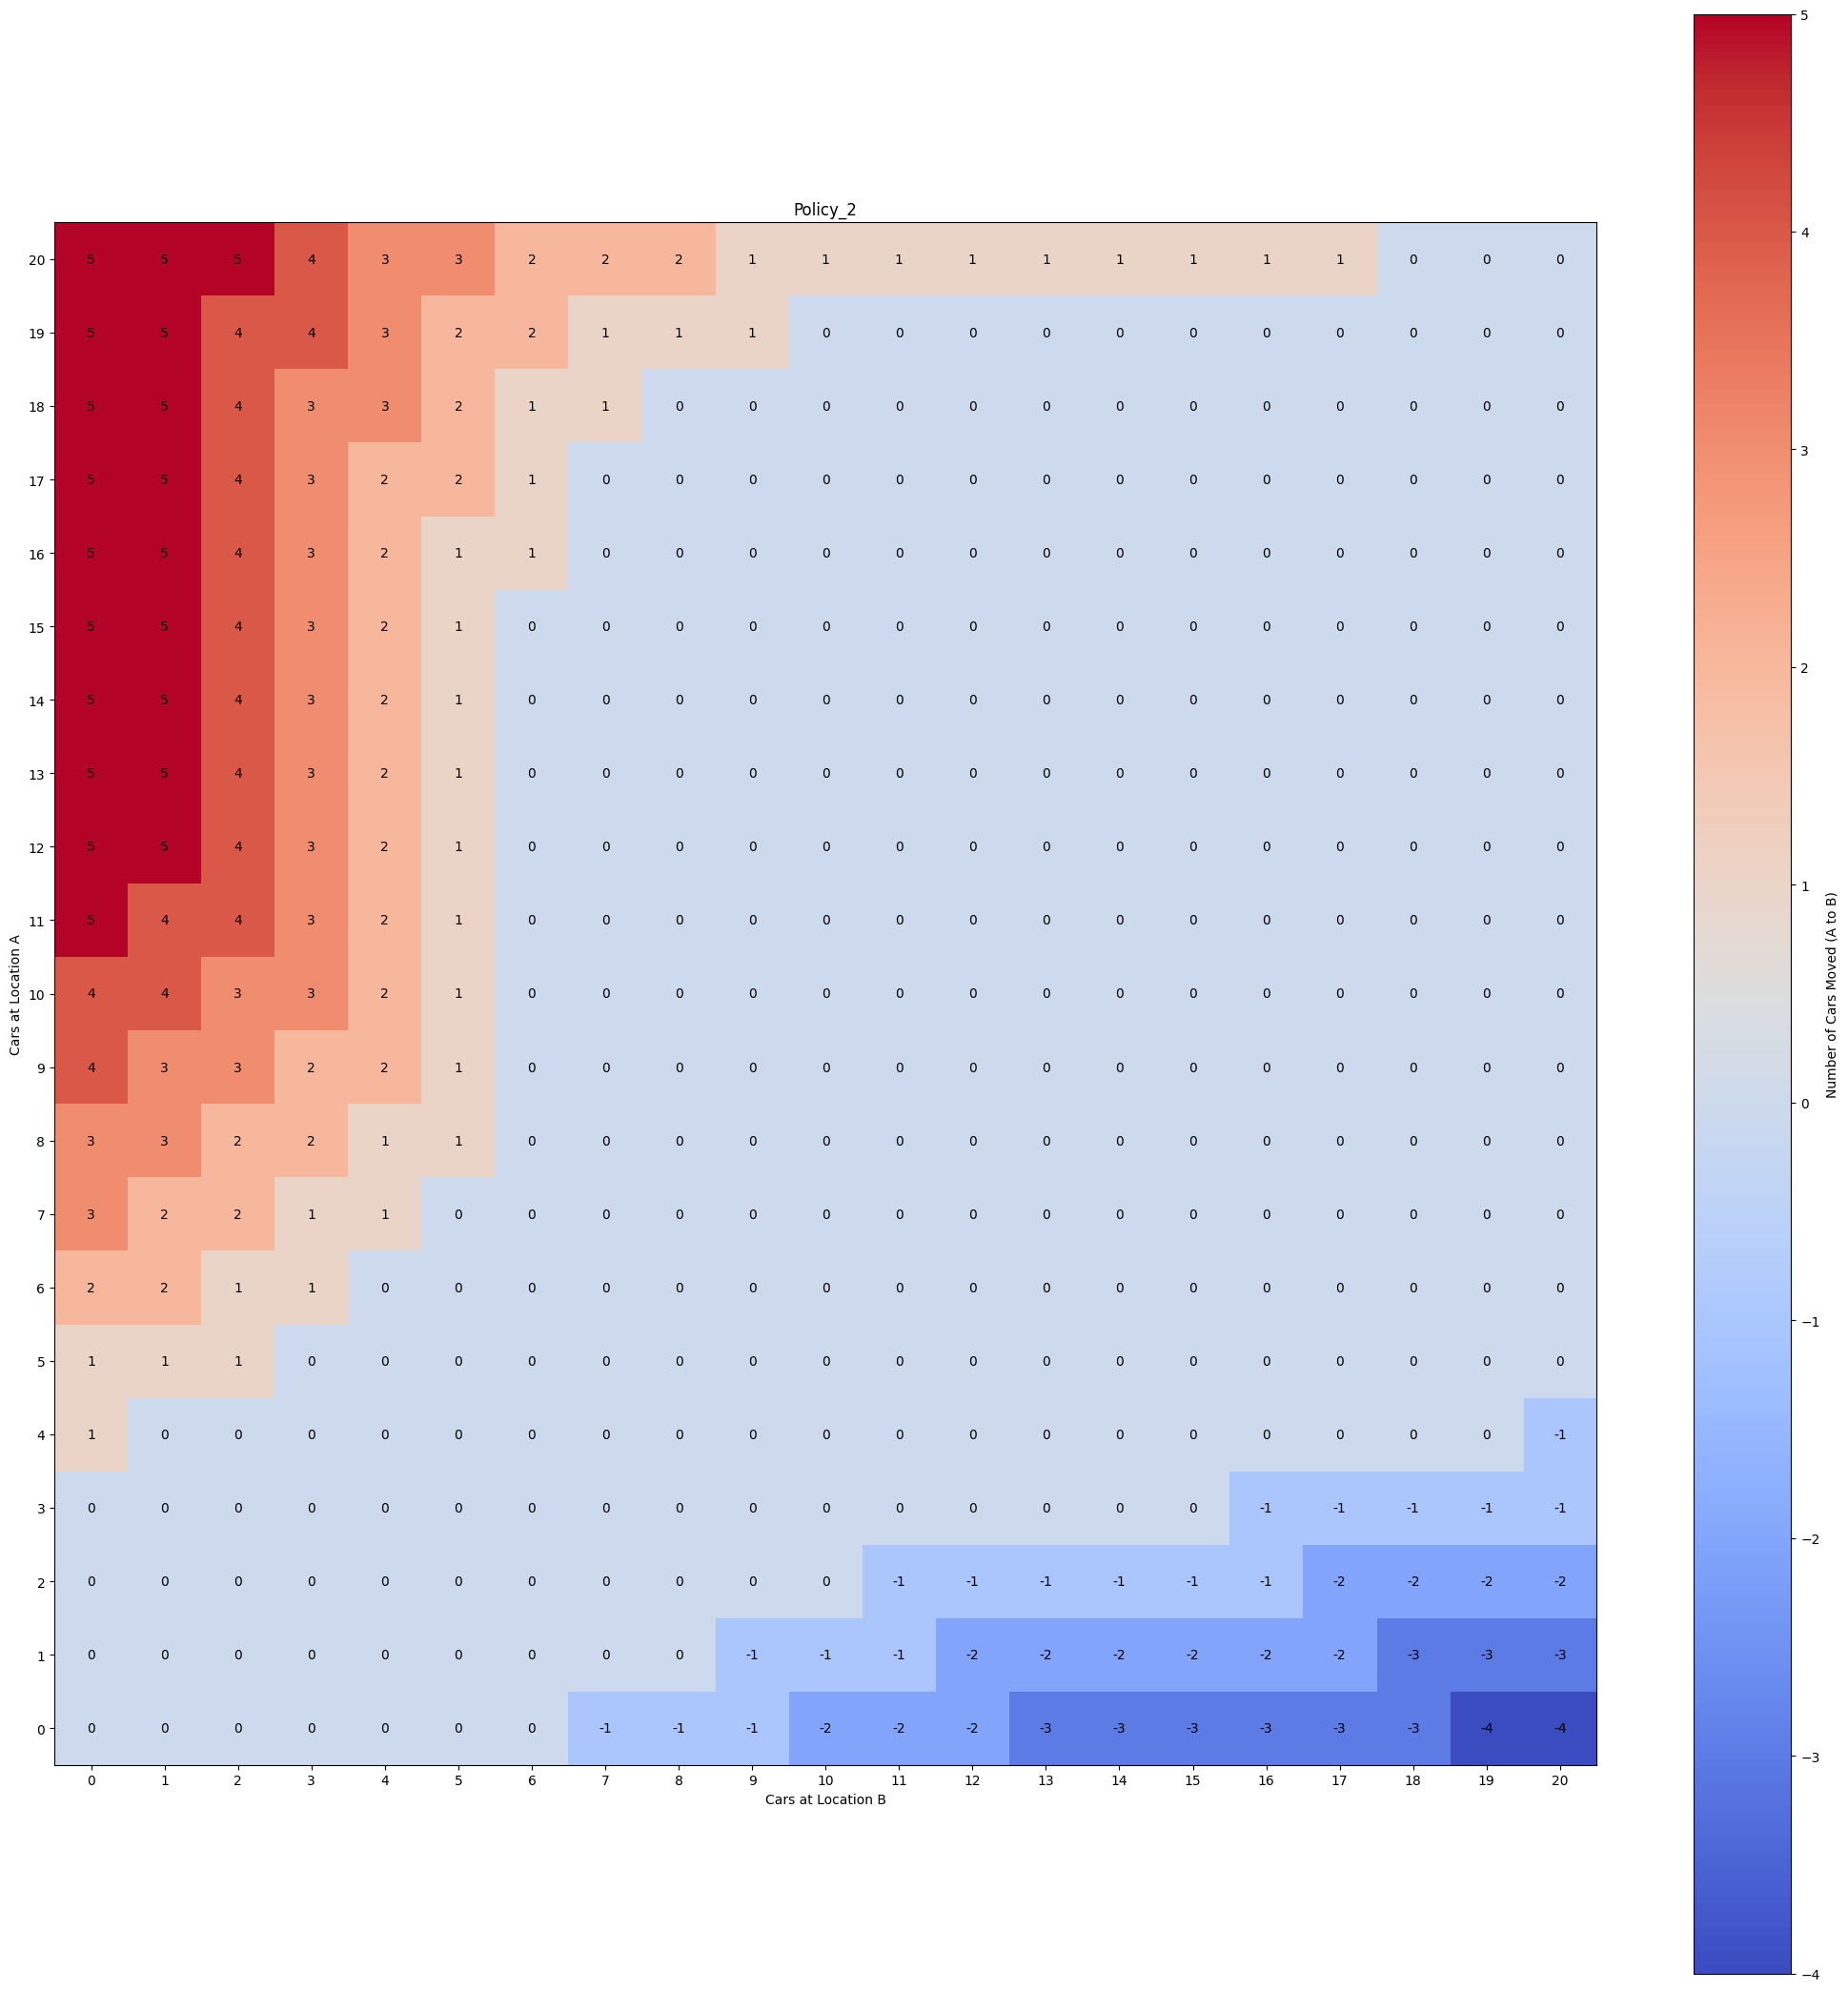

Conduct 2 time evaluation


441it [00:03, 130.06it/s]


4.276330175555813


441it [00:03, 127.18it/s]


2.8440845696137558


441it [00:03, 129.47it/s]


1.9593362073570688


441it [00:03, 128.37it/s]


1.4157966909006063


441it [00:03, 127.32it/s]


0.9785748856850205


441it [00:03, 128.79it/s]


0.6582181960575326


441it [00:03, 131.16it/s]


0.4416691494936913


441it [00:03, 128.79it/s]


0.30159235757912484


441it [00:03, 129.57it/s]


0.2240624165758618


441it [00:03, 128.32it/s]


0.17197218992794205


441it [00:03, 124.76it/s]


0.13659431675961287


441it [00:03, 129.96it/s]


0.11222812297387463


441it [00:03, 131.83it/s]


0.09209736688421799


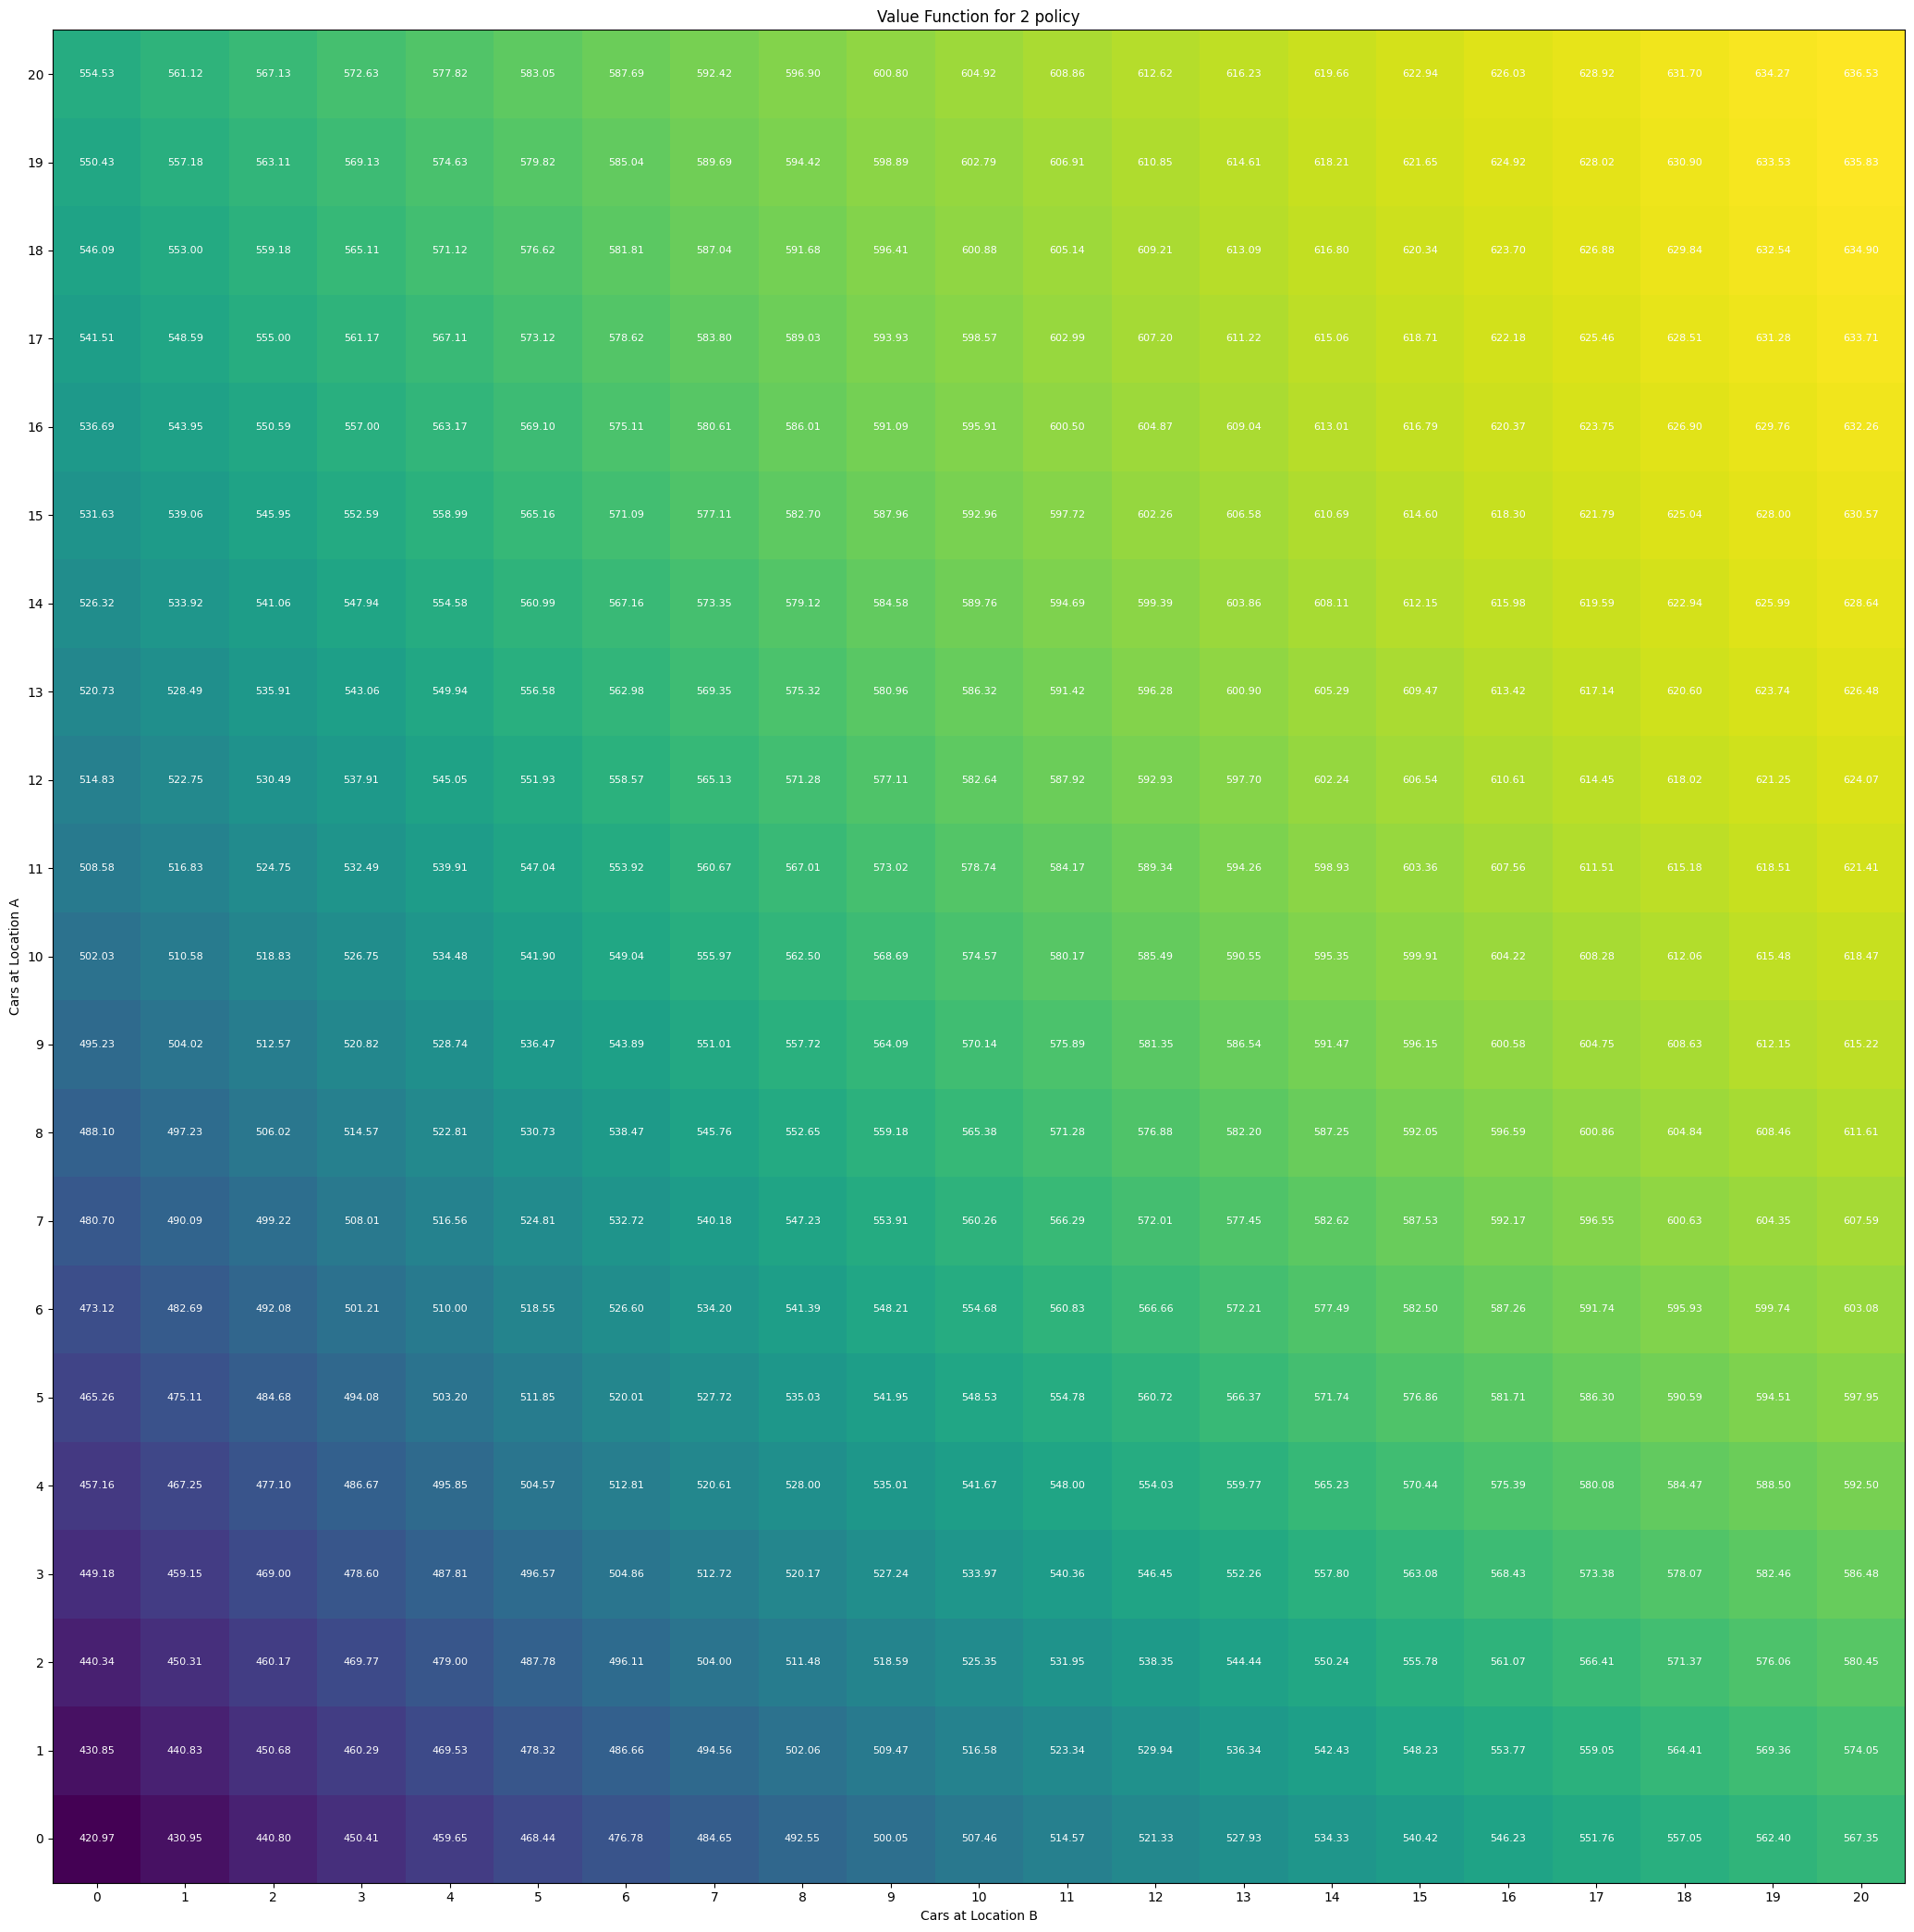

**********Staring 3 iteration


441it [00:38, 11.45it/s]


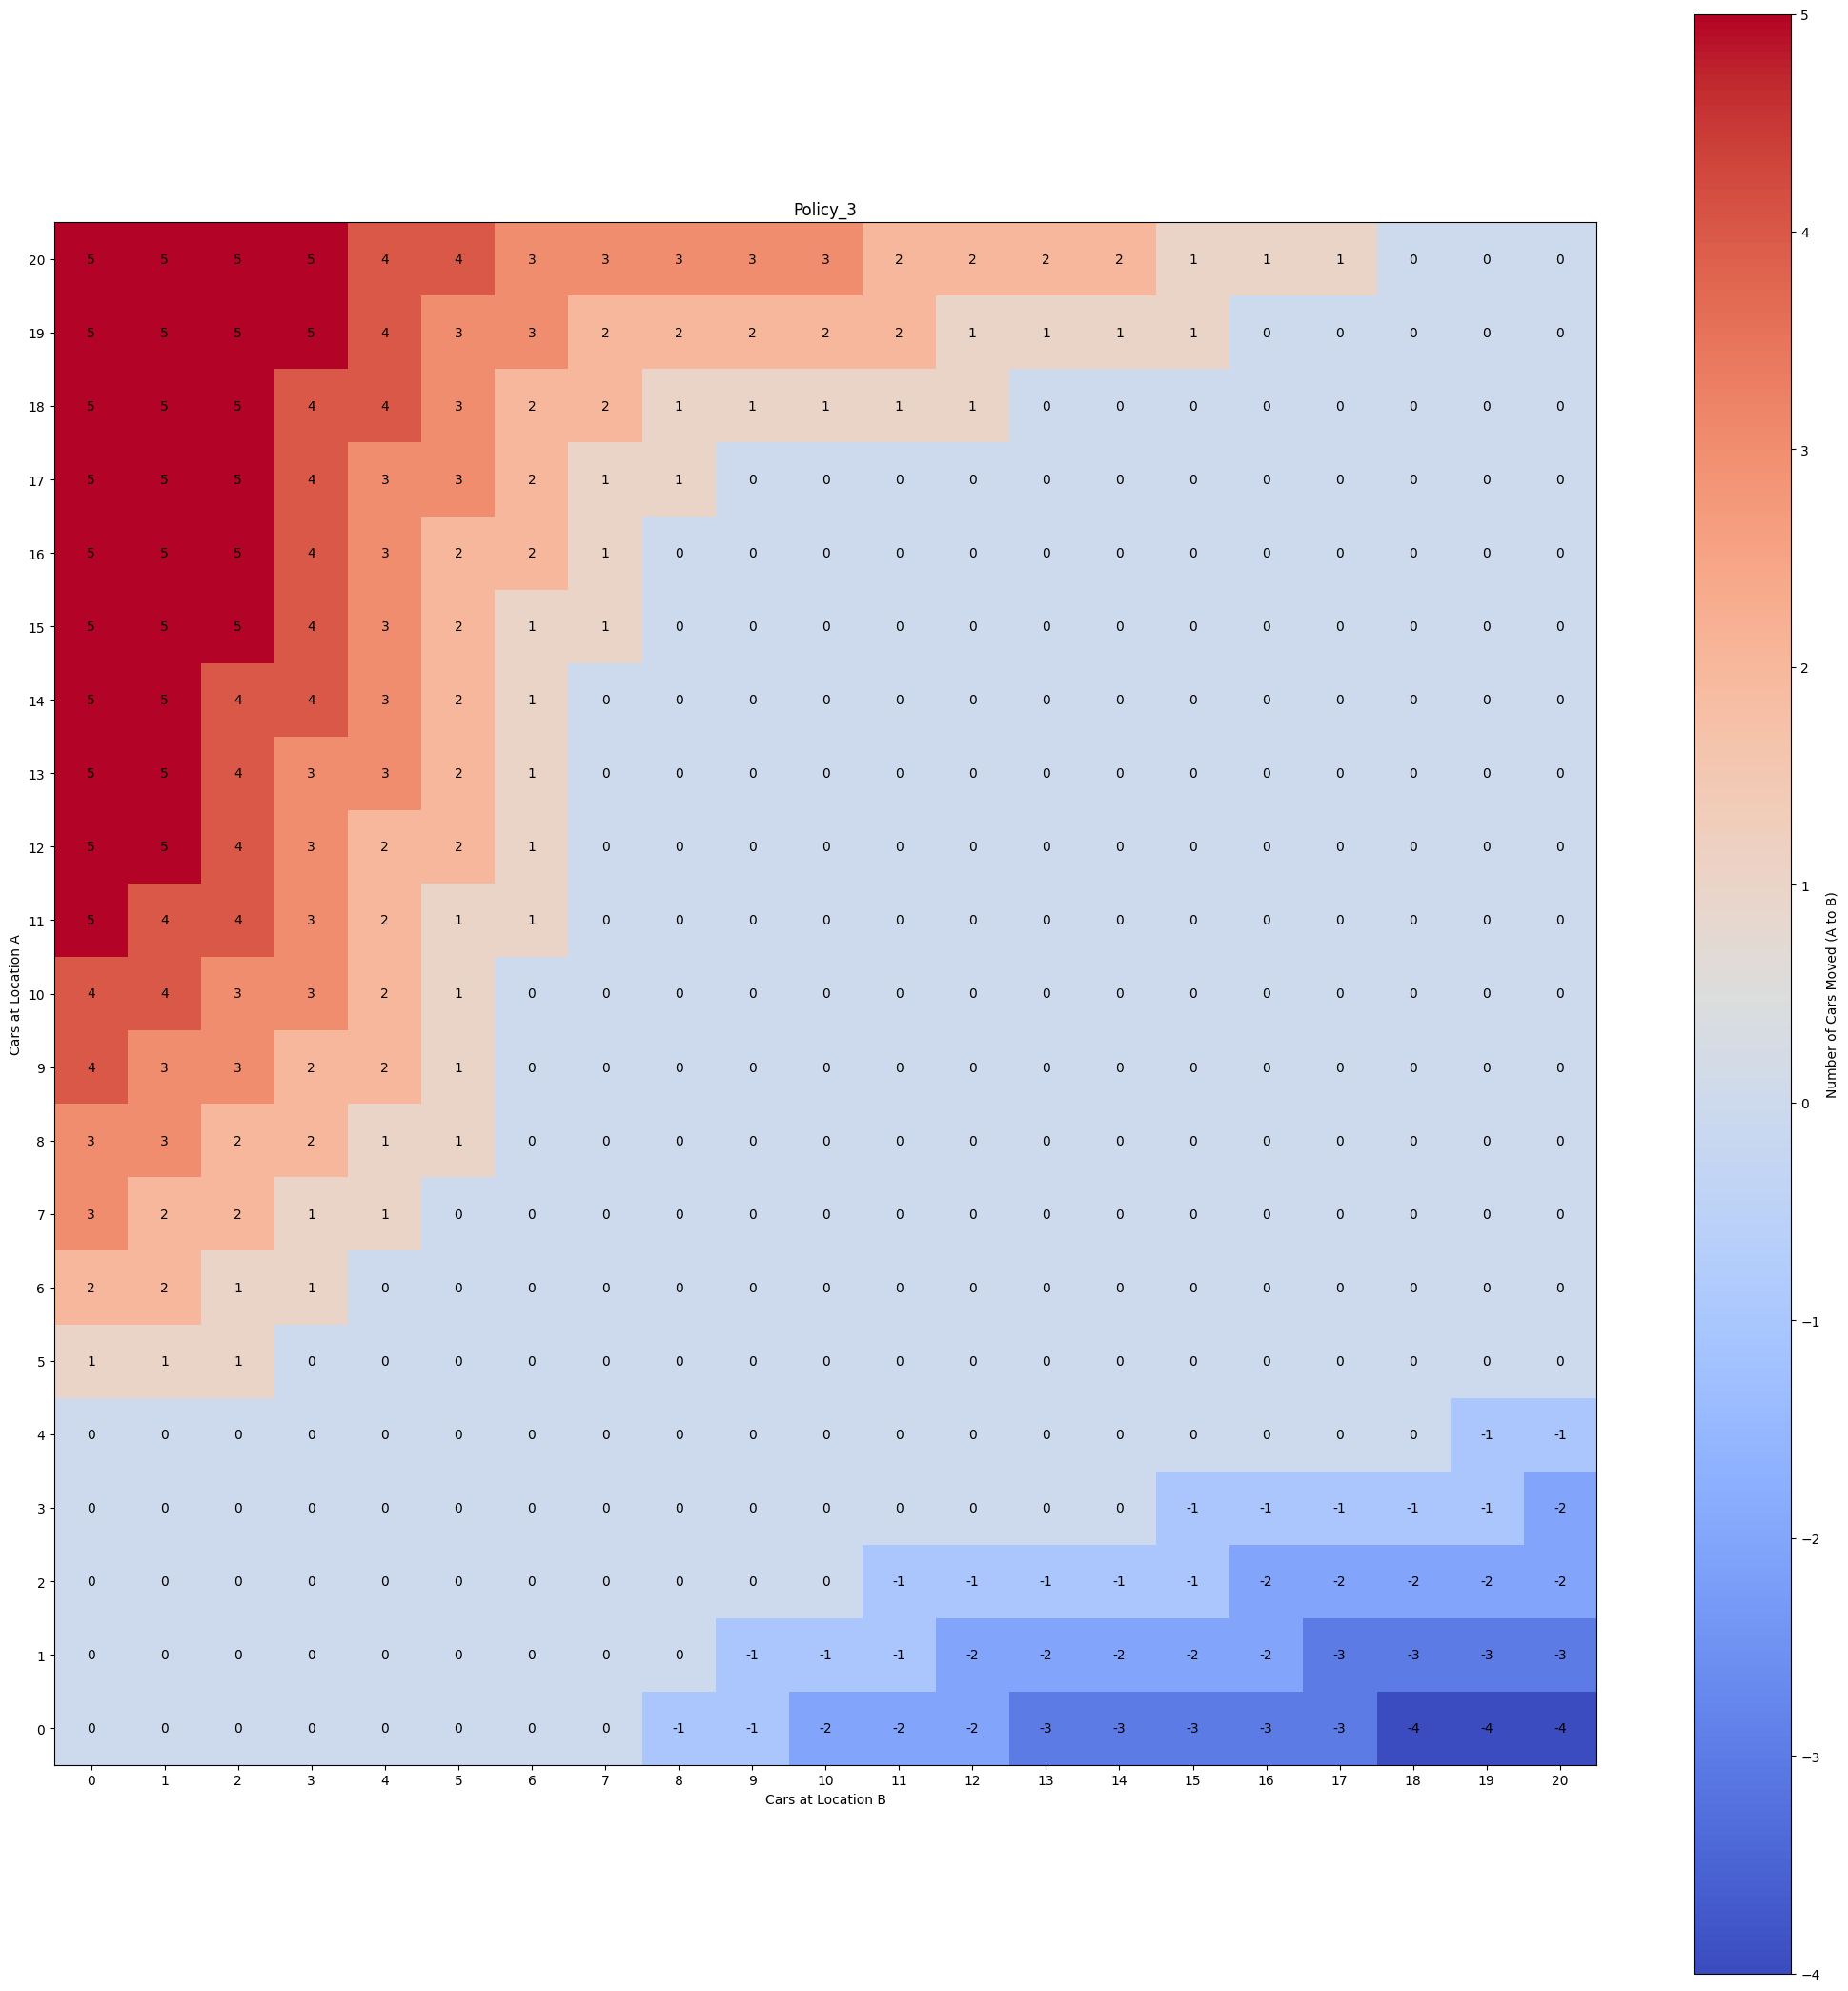

Conduct 3 time evaluation


441it [00:03, 126.89it/s]


0.5438356733992578


441it [00:03, 128.42it/s]


0.1951200427565709


441it [00:03, 127.20it/s]


0.10684838359929927


441it [00:03, 125.30it/s]


0.07076254363062162


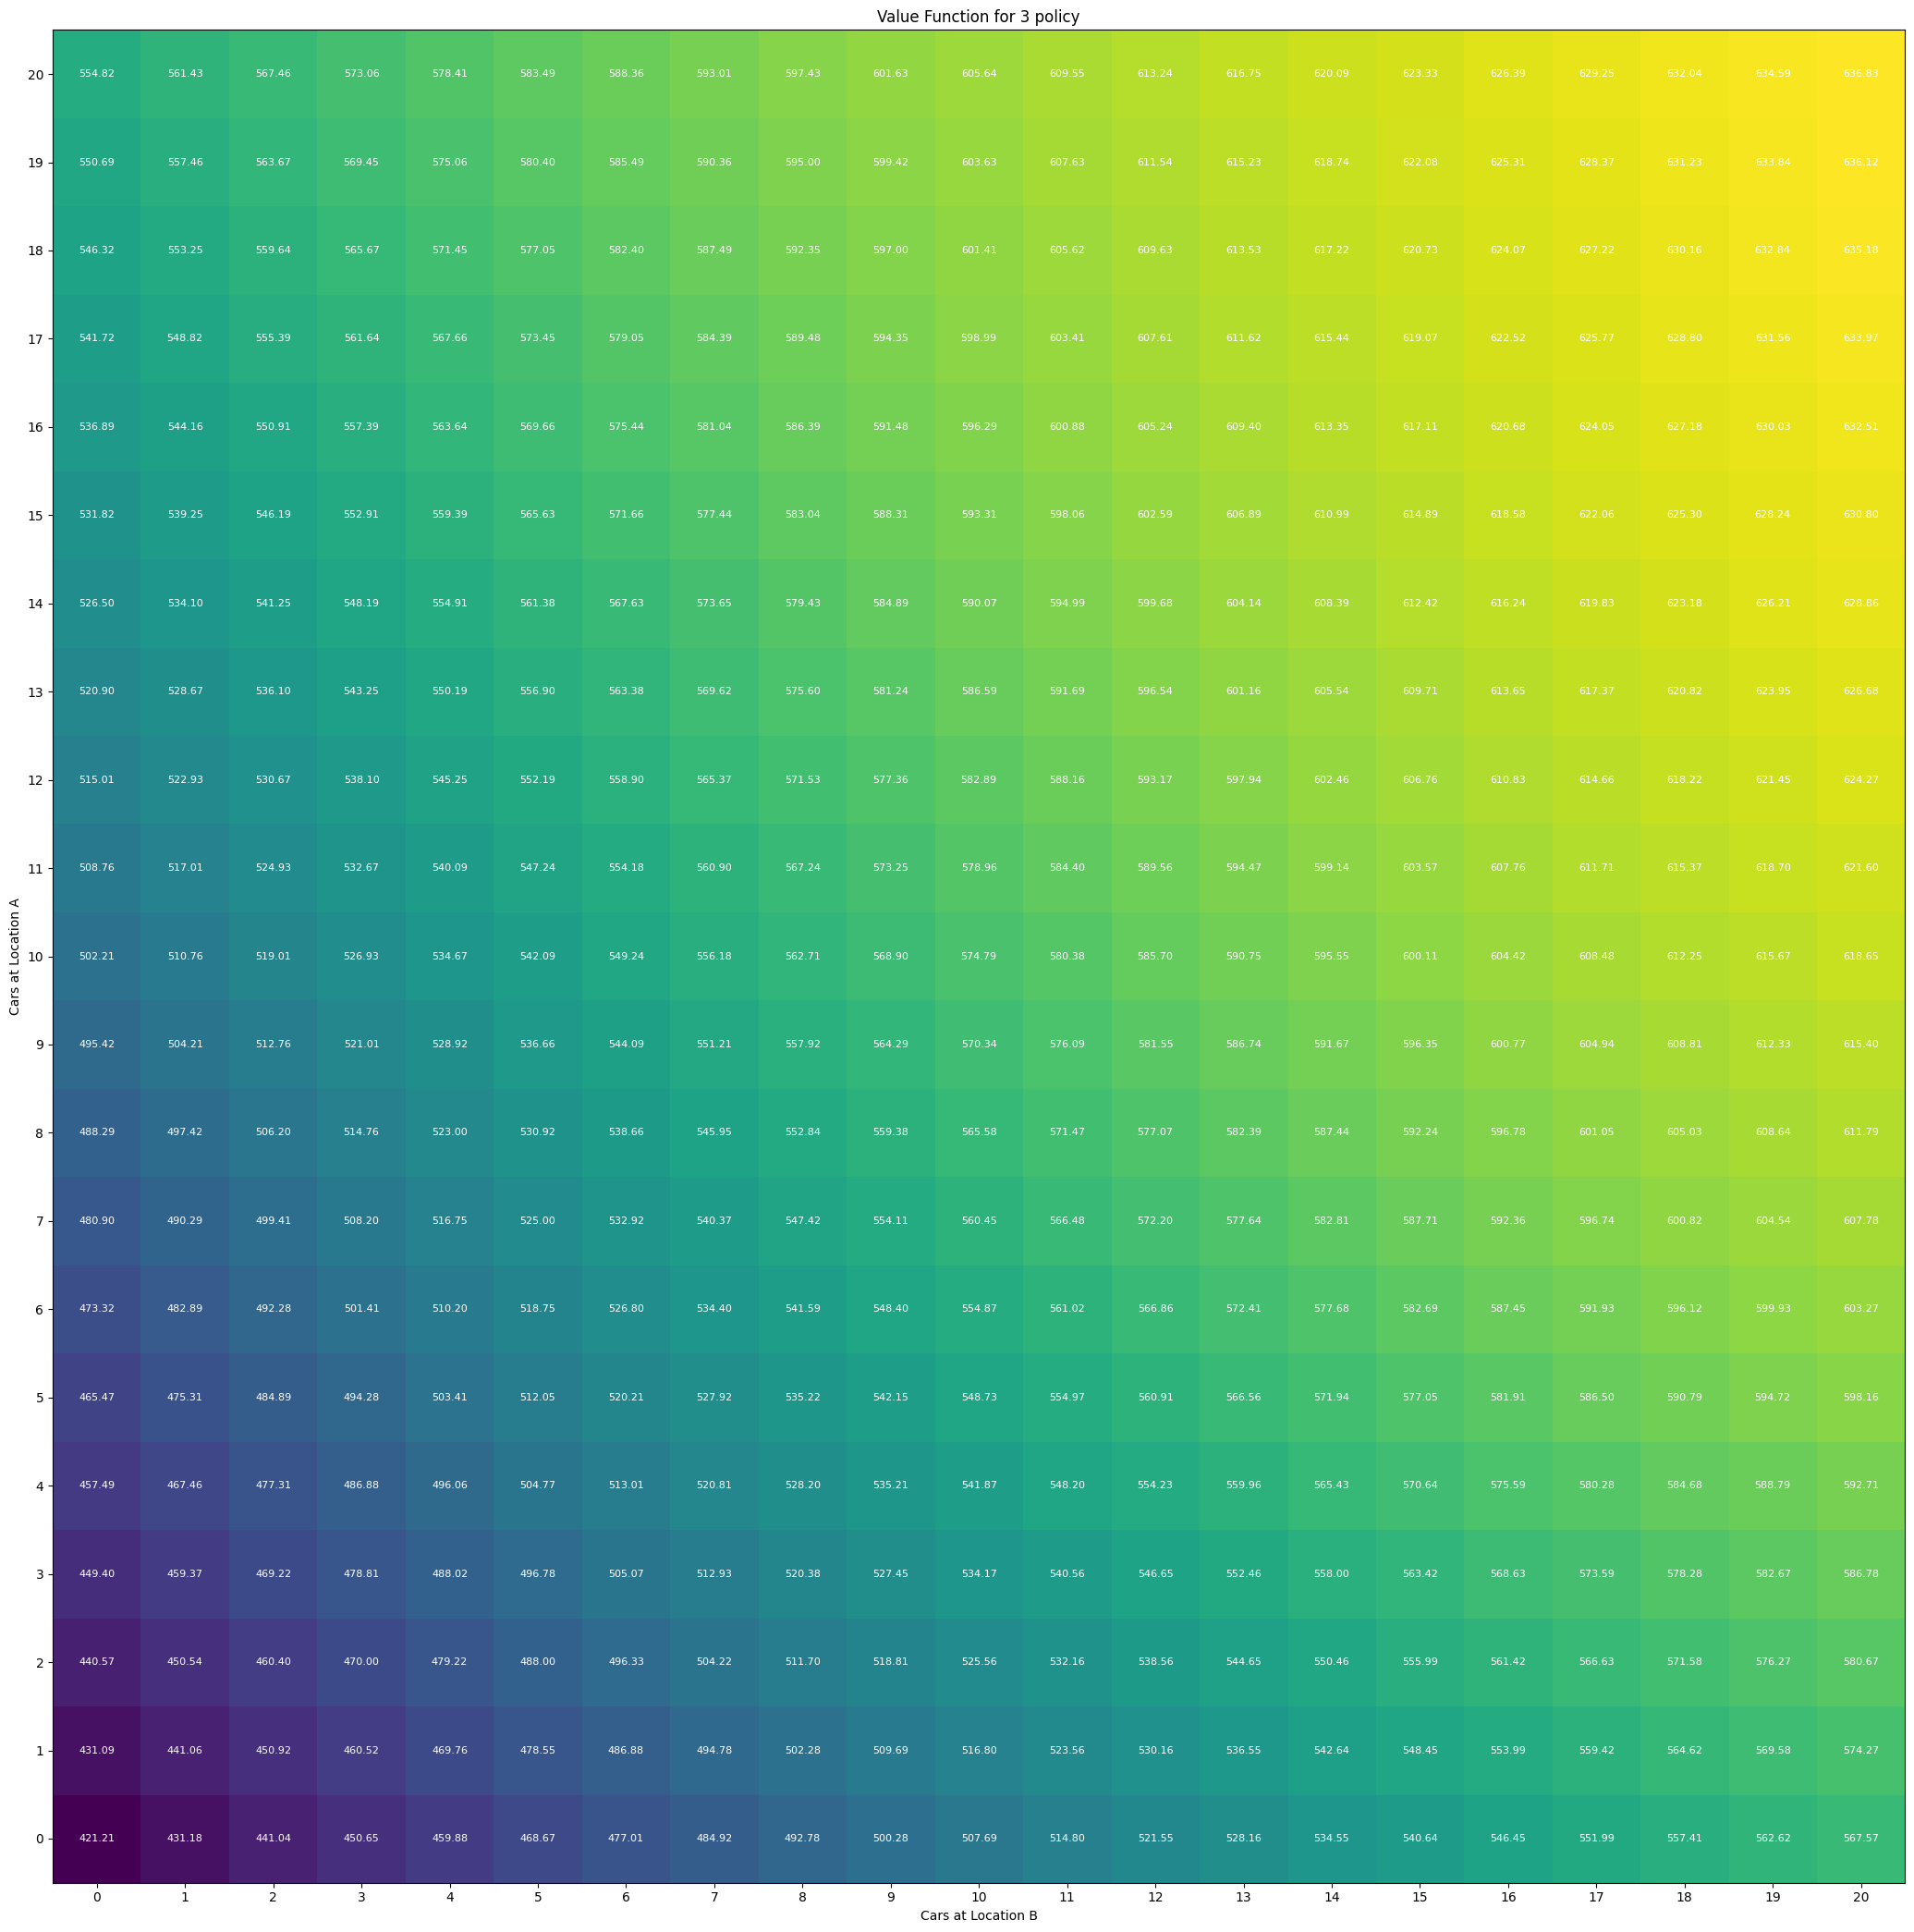

**********Staring 4 iteration


441it [00:37, 11.70it/s]


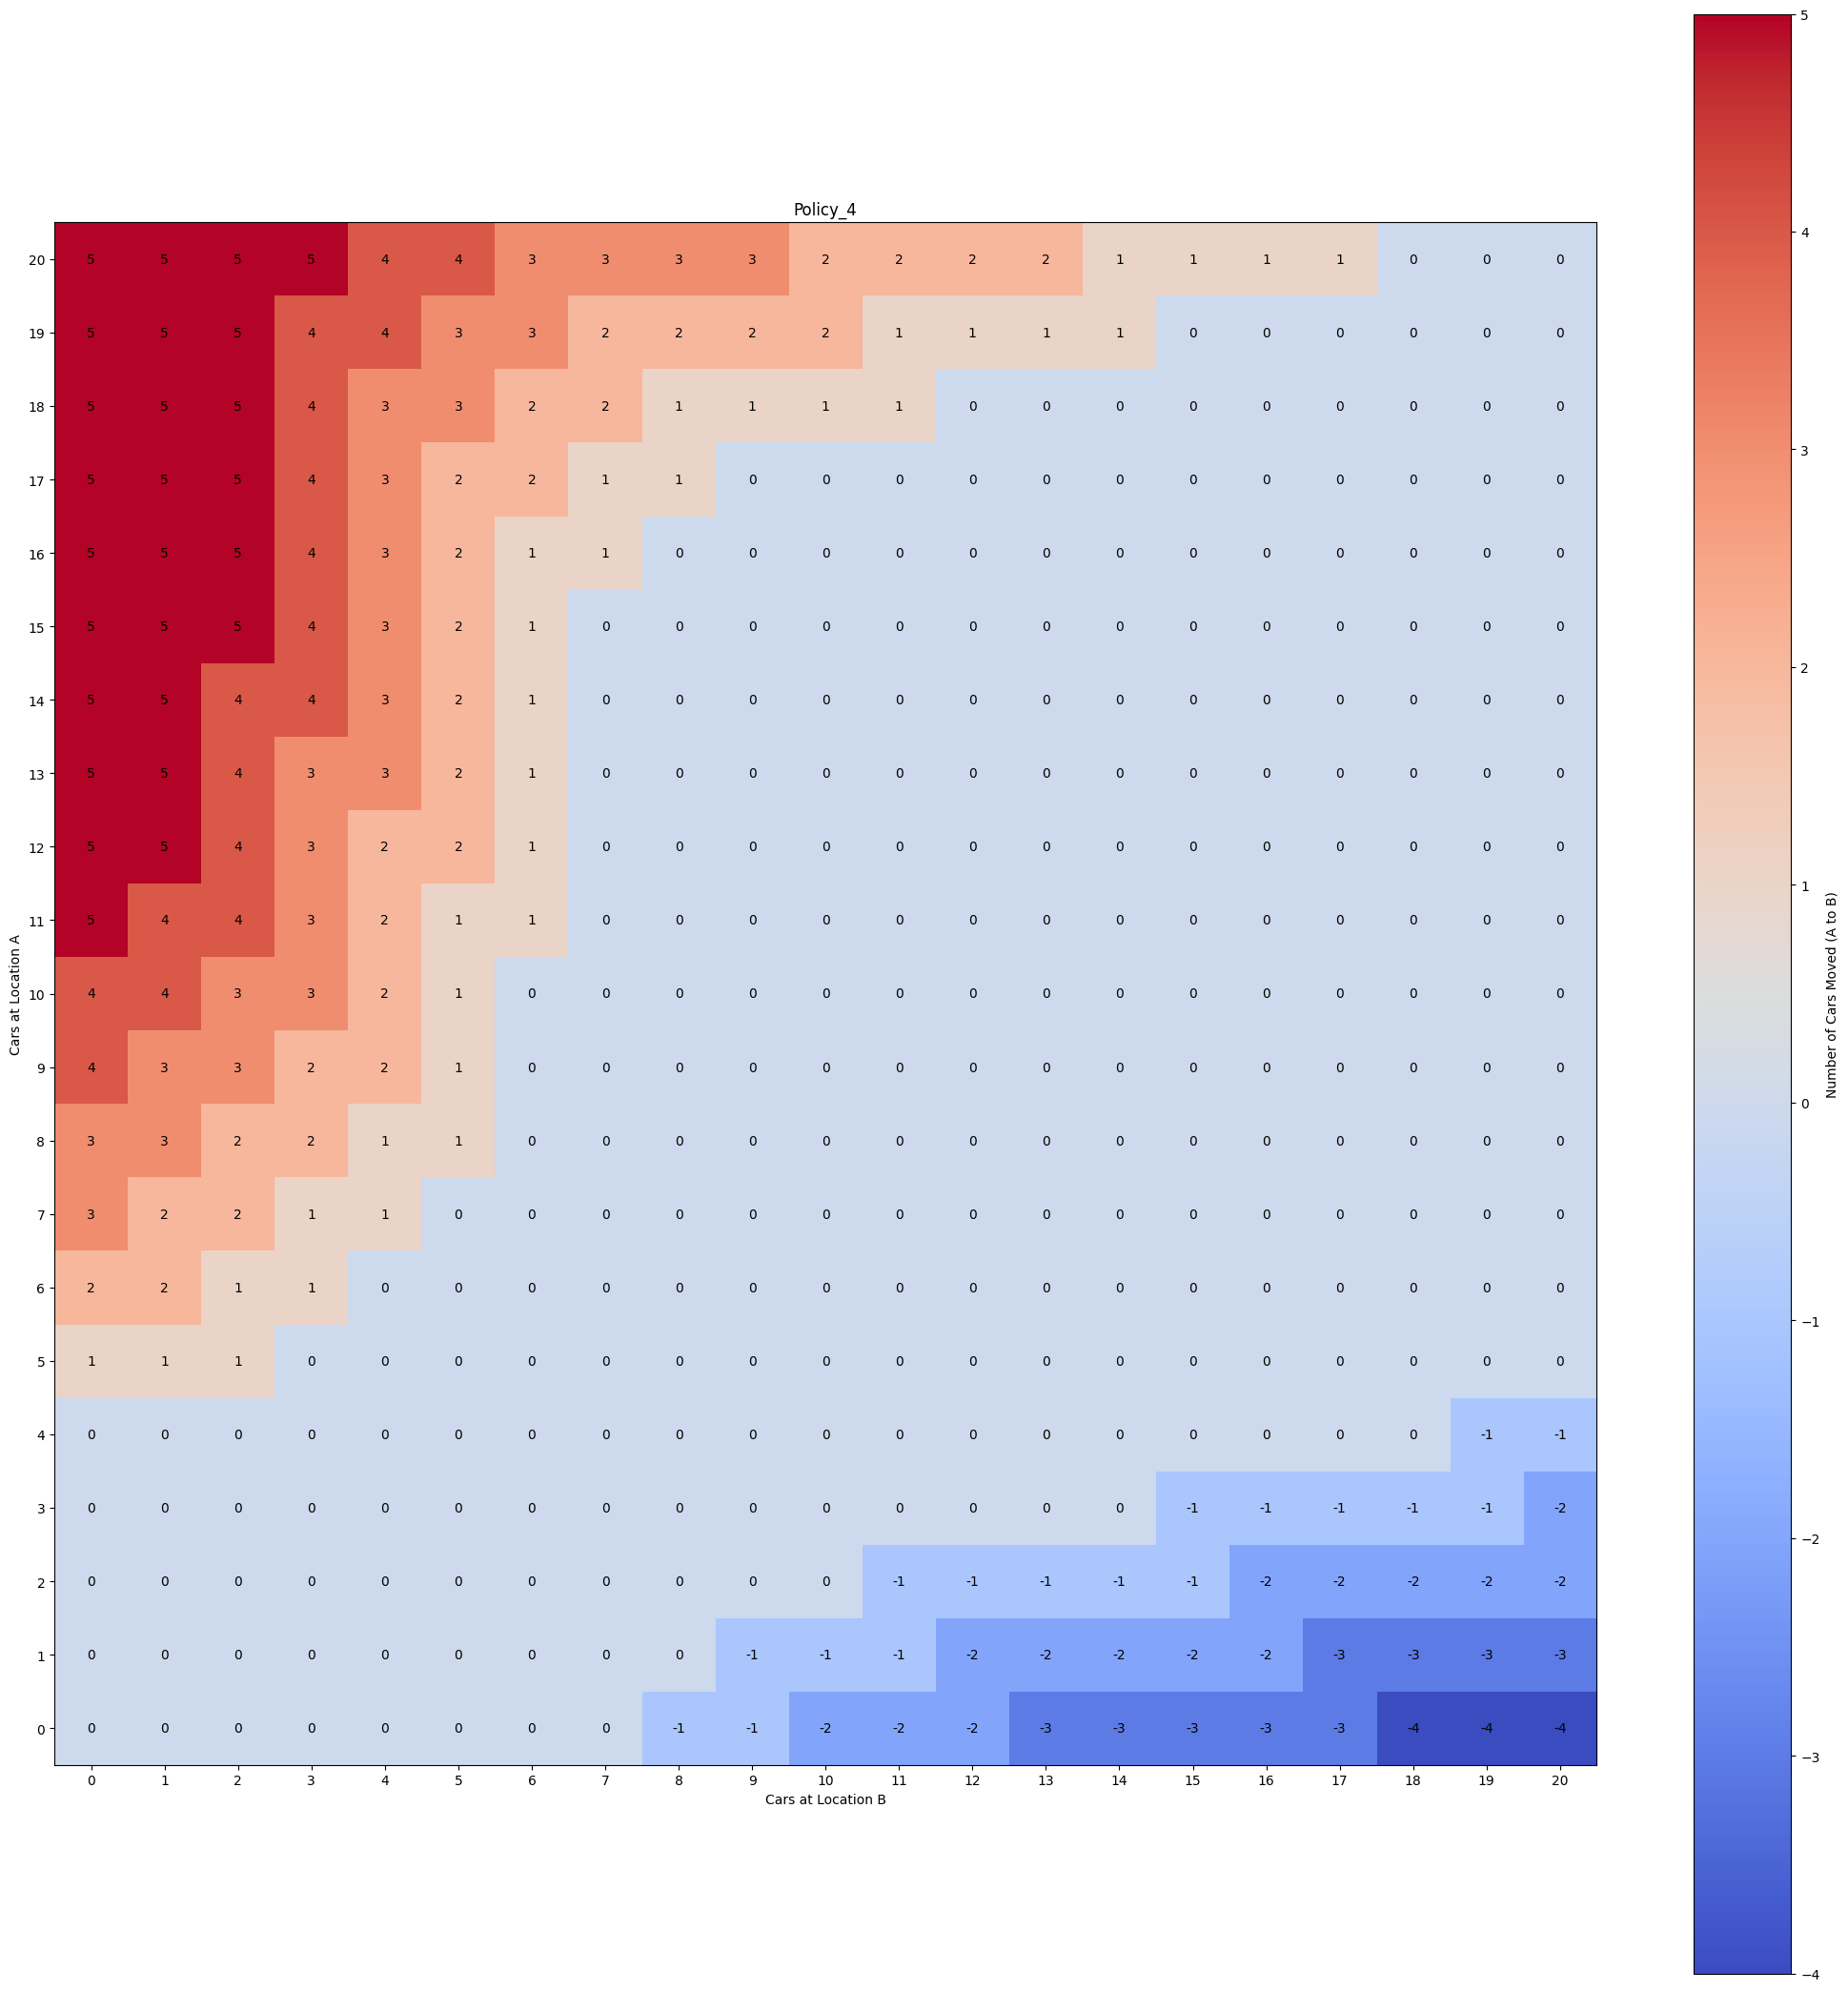

Conduct 4 time evaluation


441it [00:03, 132.12it/s]


0.07720042179539632


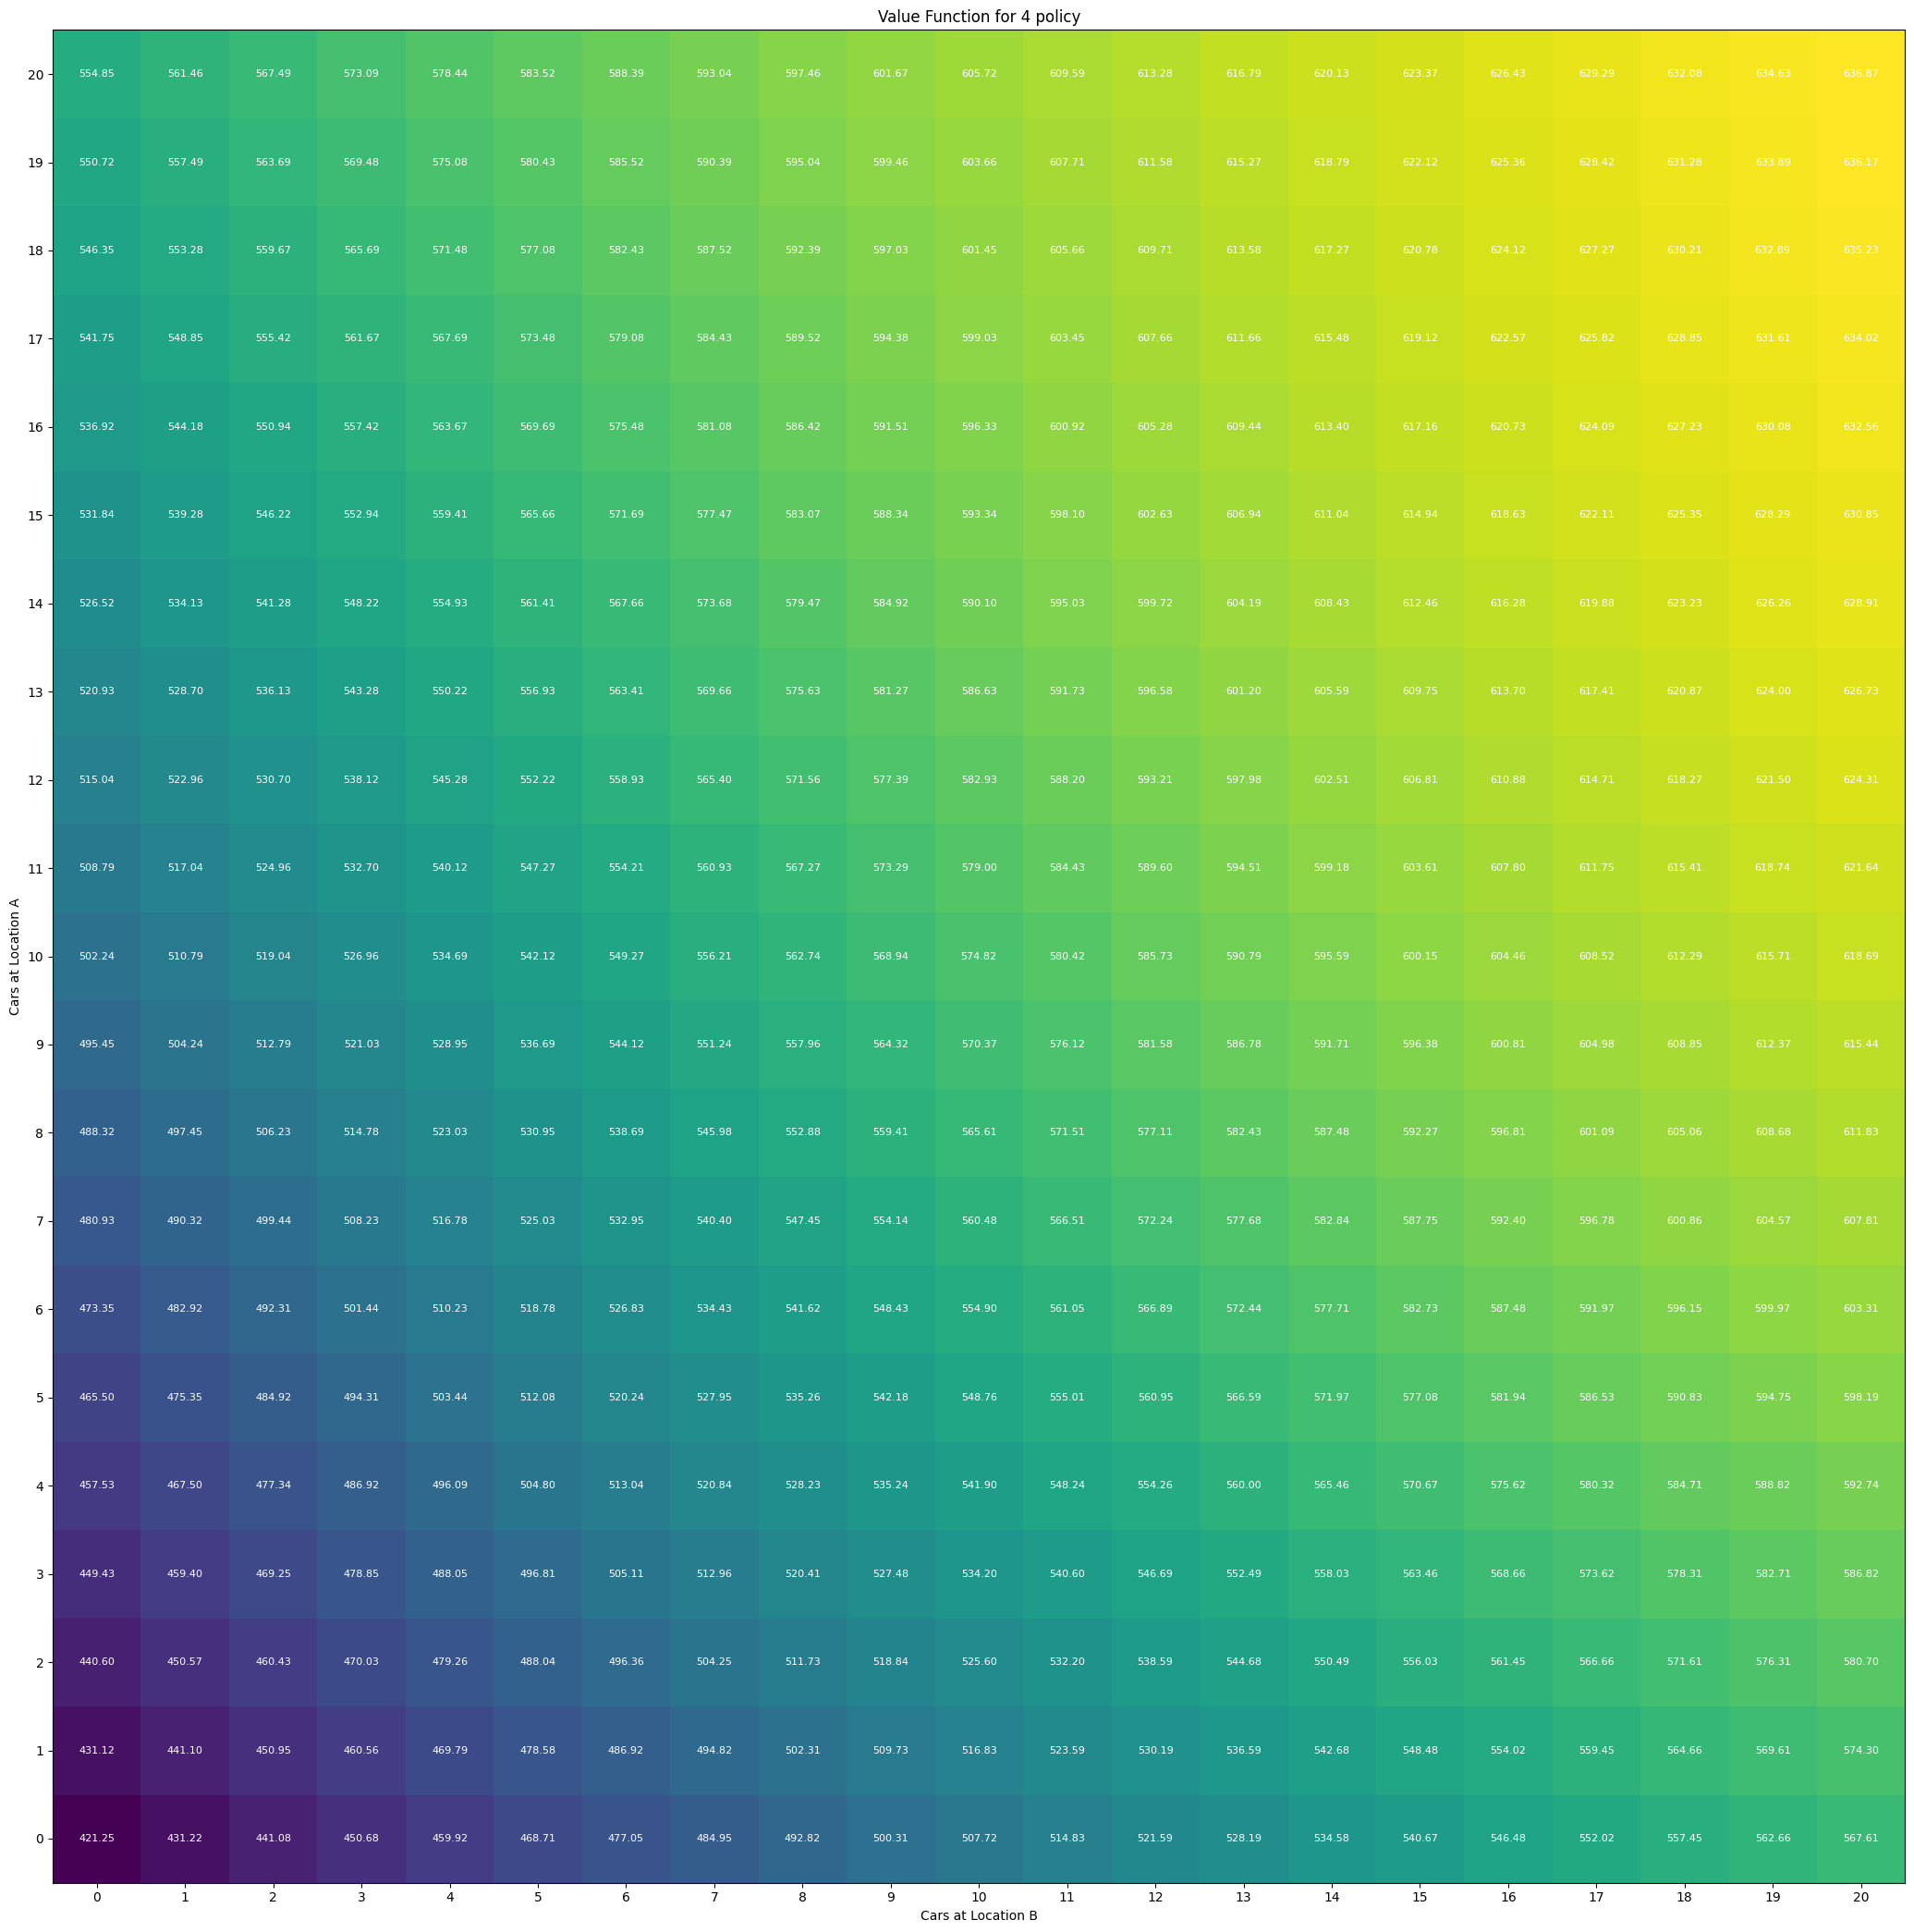

**********Staring 5 iteration


441it [00:37, 11.89it/s]


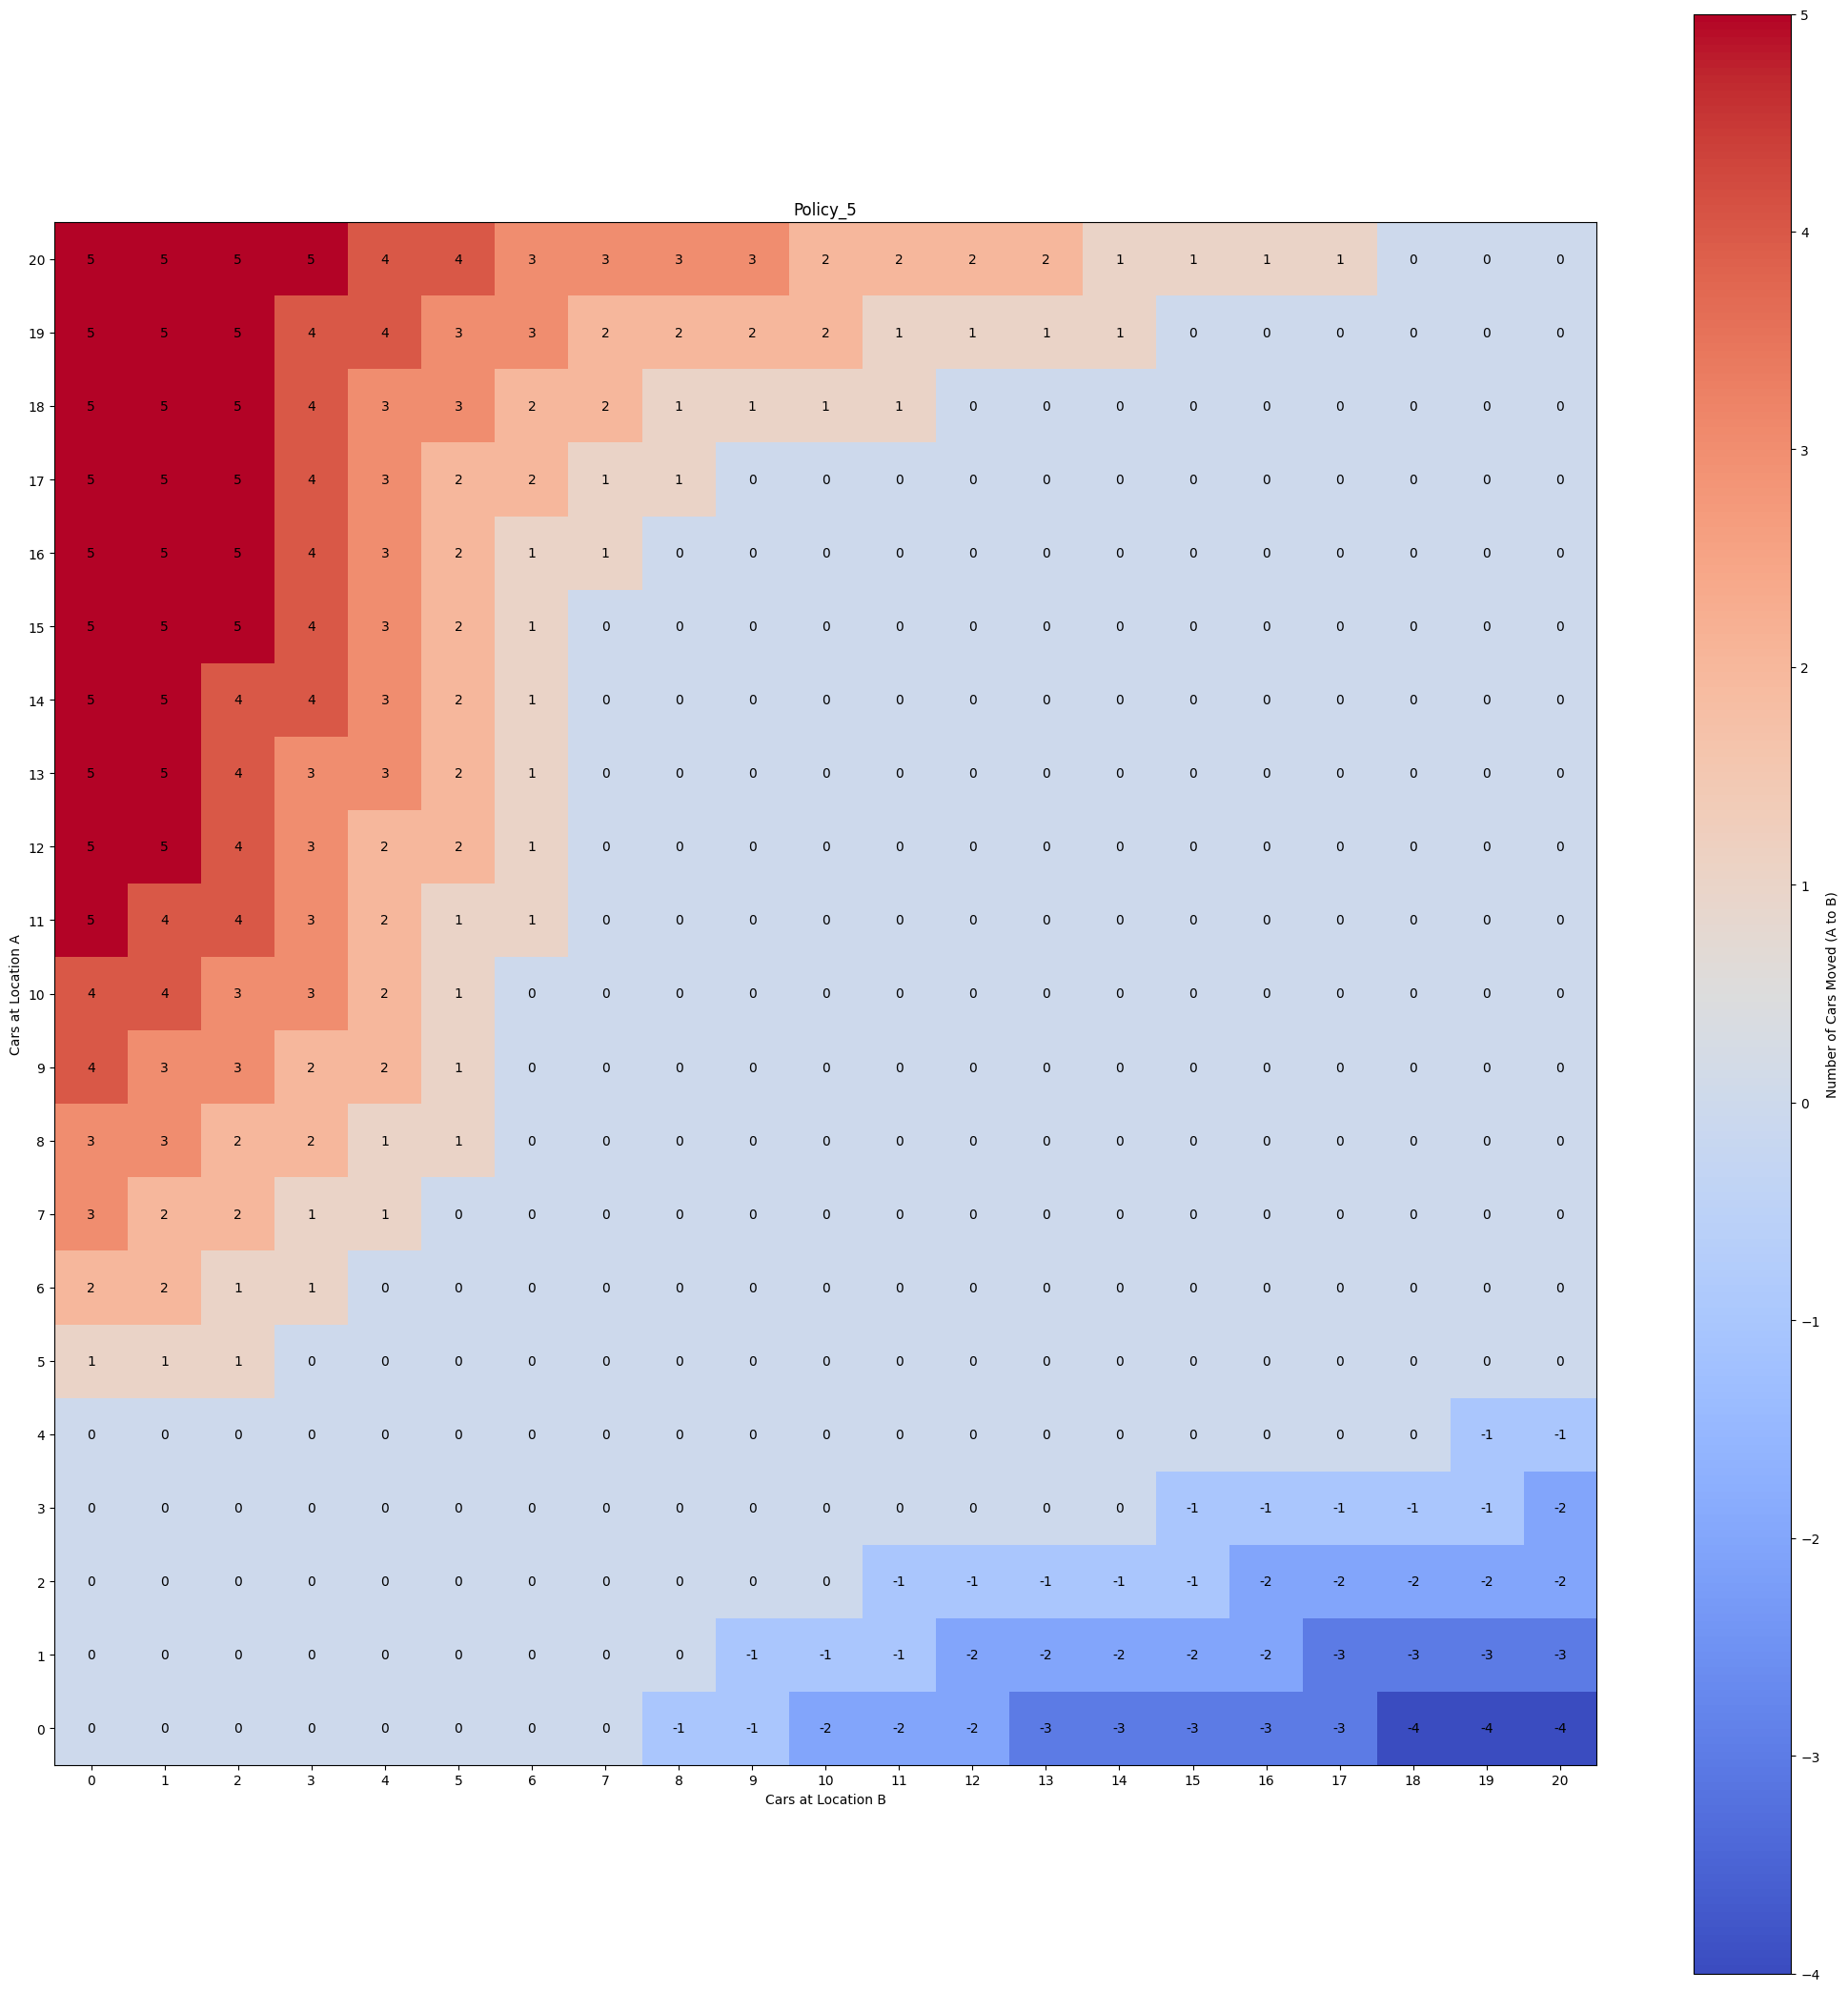

Policy reached optimal


In [133]:
agent = Agent()
policy_iteration_count = 0
print("Conduct initial Evaluation")
agent.evaluate()
while True:
    plot_value_table(agent.v_table, policy_iteration_count, CAPACITY_A, CAPACITY_B)
    policy_iteration_count += 1
    print('*' * 10 + f"Staring {policy_iteration_count} iteration")
    policy_stable = True
    for i, j in tqdm(itertools.product(range(CAPACITY_A + 1), range(CAPACITY_B + 1))):
        old_action = agent.policy[(i, j)]
        # we need to get all action value of this state and select the maximum action value as the new policy
        action_range = range(max(-j, i - CAPACITY_A, -agent.max_action), min(i, CAPACITY_B - j, agent.max_action) + 1)
        state = (i, j)
        q_values = {}
        for action in action_range:
            action_value = 0.0
            s_a = i - action
            s_b = j + action
            for n_a in range(0, s_a + 1):
                p_rent_a = calculate_probability(n_a, s_a, agent.location_a.rent_probability)
                for r_a in range(0, CAPACITY_A - (s_a - n_a) + 1):
                    p_return_a = calculate_probability(r_a, CAPACITY_A - (s_a - n_a), agent.location_a.return_probability)  # probability for return
                    p_a = p_rent_a * p_return_a
                    next_state_a = s_a - n_a + r_a

                    for n_b in range(0, s_b + 1):
                        p_rent_b = calculate_probability(n_b, s_b, agent.location_b.rent_probability)
                        reward = (n_a + n_b) * 10. - abs(action) * 2.
                        for r_b in range(0, CAPACITY_B - (s_b - n_b) + 1):
                            p_return_b = calculate_probability(r_b, CAPACITY_B - (s_b - n_b), agent.location_b.return_probability)  # probability for return
                            p_b = p_rent_b * p_return_b
                            next_state_b = s_b - n_b + r_b

                            p = p_a * p_b
                            next_state = (next_state_a, next_state_b)
                            value_next_state = agent.v_table[next_state]
                            action_value += p * (reward + agent.gamma * value_next_state)
            q_values[(i, j, action)] = action_value
        
        max_action = max(q_values, key=q_values.get)[2]
        agent.policy[(i, j)] = max_action
        if old_action != max_action:
            policy_stable = False

    plot_policy(agent.policy, policy_iteration_count, CAPACITY_A, CAPACITY_B)
    if policy_stable:
        print('Policy reached optimal')
        break
    print(f"Conduct {policy_iteration_count} time evaluation")
    agent.evaluate()
